In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import shutil

# Đường dẫn thư mục làm việc
working_dir = "/kaggle/working"

# Xóa tất cả file và thư mục con trong /kaggle/working
for filename in os.listdir(working_dir):
    file_path = os.path.join(working_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Xóa file
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Xóa thư mục
    except Exception as e:
        print(f"Không thể xóa {file_path}: {e}")

print("✅ Đã xóa toàn bộ file cũ trong /kaggle/working")


✅ Đã xóa toàn bộ file cũ trong /kaggle/working


In [3]:
"""
Complete WSN Clustering Simulation with 100 Nodes
- 3 Distribution Scenarios: Uniform Random, Corner-Biased, Clustered
- 3 Algorithms: AC-ACO, Basic ACO, GA
- Full logging every 250 rounds
- Input/Output file export
"""

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from typing import List, Tuple, Dict
import json
import csv
from datetime import datetime
import os

# Set random seed
np.random.seed(42)

In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [5]:
# ============================================================================
# NETWORK PARAMETERS (for 200-node WSN)
# ============================================================================

from dataclasses import dataclass, asdict
from typing import Tuple
import numpy as np

@dataclass
class NetworkParams:
    """Network parameters for WSN with 200 nodes"""
    area_size: Tuple[int, int] = (250, 250)
    n_nodes: int = 500                      # ✅ changed from 200 → 200
    BS_location: Tuple[float, float] = (125.0, 125.0)
    R: float = 20.0
    packet_length: int = 2000
    ctrl_packet_length: int = 100
    E0: float = 0.6                         # ✅ increased from 0.5 → 0.6
    Eelec: float = 50e-9
    Efs: float = 10e-12
    Emp: float = 0.0013e-12
    EDA: float = 5e-9
    p_CH: float = 0.1
    Tmax: int = 3500                        # ✅ simulation rounds = 2500

# ============================================================================
# NETWORK PARAMETERS (for 200-node WSN)
# ============================================================================

from dataclasses import dataclass, asdict
from typing import Tuple
import numpy as np

@dataclass
class NetworkParams:
    """Network parameters for WSN with 200 nodes"""
    area_size: Tuple[int, int] = (250, 250)
    n_nodes: int = 500                      # ✅ changed from 200 → 200
    BS_location: Tuple[float, float] = (125.0, 125.0)
    R: float = 20.0
    packet_length: int = 2000
    ctrl_packet_length: int = 100
    E0: float = 0.6                         # ✅ increased from 0.5 → 0.6
    Eelec: float = 50e-9
    Efs: float = 10e-12
    Emp: float = 0.0013e-12
    EDA: float = 5e-9
    p_CH: float = 0.1
    Tmax: int = 3500                        # ✅ simulation rounds = 2500

    def __post_init__(self):
        self.d0 = np.sqrt(self.Efs / self.Emp)

    # def to_dict(self):
    #     return asdict(self)
    def to_dict(self):
        return {
            'area_size': self.area_size,
            'n_nodes': self.n_nodes,
            'BS_location': self.BS_location,
            'R': self.R,
            'packet_length': self.packet_length,
            'ctrl_packet_length': self.ctrl_packet_length,
            'E0': self.E0,
            'Eelec': self.Eelec,
            'Efs': self.Efs,
            'Emp': self.Emp,
            'EDA': self.EDA,
            'p_CH': self.p_CH,
            'Tmax': self.Tmax,
            'd0': self.d0
        }

    # def to_dict(self):
    #     return asdict(self)
    def to_dict(self):
        return {
            'area_size': self.area_size,
            'n_nodes': self.n_nodes,
            'BS_location': self.BS_location,
            'R': self.R,
            'packet_length': self.packet_length,
            'ctrl_packet_length': self.ctrl_packet_length,
            'E0': self.E0,
            'Eelec': self.Eelec,
            'Efs': self.Efs,
            'Emp': self.Emp,
            'EDA': self.EDA,
            'p_CH': self.p_CH,
            'Tmax': self.Tmax,
            'd0': self.d0
        }

In [6]:
# ============================================================================
# NODE AND NETWORK CLASSES
# ============================================================================

class Node:
    def __init__(self, idx: int, x: float, y: float, energy: float):
        self.idx = idx
        self.x = x
        self.y = y
        self.energy = energy
        self.is_alive = True
        self.is_CH = False

    def distance_to(self, other) -> float:
        if isinstance(other, Node):
            return np.sqrt((self.x - other.x)**2 + (self.y - other.y)**2)
        else:
            return np.sqrt((self.x - other[0])**2 + (self.y - other[1])**2)


# class WSN:
#     def __init__(self, params: NetworkParams, node_positions: List[Tuple[float, float]] = None):
#         self.params = params
#         self.nodes = self._initialize_nodes(node_positions)

class WSN:
    def __init__(self, params, node_positions):
        self.params = params
        self.n = params.n_nodes

        self.nodes = self._initialize_nodes(node_positions)
    
        pos = torch.tensor(node_positions, dtype=torch.float32, device=device)
        self.x = pos[:, 0]
        self.y = pos[:, 1]
        
        self.energy = torch.full((self.n,), params.E0, device=device)
        self.alive = torch.ones(self.n, dtype=torch.bool, device=device)
    
      

    def _initialize_nodes(self, positions: List[Tuple[float, float]] = None) -> List[Node]:
        nodes = []
        if positions:
            for i, (x, y) in enumerate(positions):
                node = Node(i, x, y, self.params.E0)
                nodes.append(node)
        else:
            for i in range(self.params.n_nodes):
                x = np.random.uniform(0, self.params.area_size[0])
                y = np.random.uniform(0, self.params.area_size[1])
                node = Node(i, x, y, self.params.E0)
                nodes.append(node)
        return nodes

    def get_alive_nodes(self):
        return [self.nodes[i] for i in range(self.n) if self.alive[i]]


    # def calculate_energy_consumption(self, CH_indices: List[int],
    #                                  clusters: Dict[int, List[int]]) -> np.ndarray:
    #     E_consumed = np.zeros(self.params.n_nodes)

    #     for ch_idx in CH_indices:
    #         ch_node = self.nodes[ch_idx]
    #         if not ch_node.is_alive:
    #             continue

    #         member_indices = clusters.get(ch_idx, [])
    #         E_agg = self.params.EDA * self.params.packet_length * len(member_indices)
    #         E_consumed[ch_idx] += E_agg

    #         for member_idx in member_indices:
    #             member = self.nodes[member_idx]
    #             if not member.is_alive:
    #                 continue

    #             dist = member.distance_to(ch_node)

    #             if dist < self.params.d0:
    #                 E_tx_ctrl = (self.params.Eelec * self.params.ctrl_packet_length +
    #                              self.params.Efs * self.params.ctrl_packet_length * dist**2)
    #             else:
    #                 E_tx_ctrl = (self.params.Eelec * self.params.ctrl_packet_length +
    #                              self.params.Emp * self.params.ctrl_packet_length * dist**4)
    #             E_consumed[member_idx] += E_tx_ctrl

    #             E_rx_ctrl = self.params.Eelec * self.params.ctrl_packet_length
    #             E_consumed[ch_idx] += E_rx_ctrl

    #             if dist < self.params.d0:
    #                 E_tx = (self.params.Eelec * self.params.packet_length +
    #                         self.params.Efs * self.params.packet_length * dist**2)
    #             else:
    #                 E_tx = (self.params.Eelec * self.params.packet_length +
    #                         self.params.Emp * self.params.packet_length * dist**4)
    #             E_consumed[member_idx] += E_tx

    #             E_rx = self.params.Eelec * self.params.packet_length
    #             E_consumed[ch_idx] += E_rx

    #         dist_BS = ch_node.distance_to(self.params.BS_location)
    #         total_data_length = self.params.packet_length
    #         if dist_BS < self.params.d0:
    #             E_tx_BS = (self.params.Eelec * total_data_length +
    #                        self.params.Efs * total_data_length * dist_BS**2)
    #         else:
    #             E_tx_BS = (self.params.Eelec * total_data_length +
    #                        self.params.Emp * total_data_length * dist_BS**4)
    #         E_consumed[ch_idx] += E_tx_BS

    #     return E_consumed


    def calculate_energy_consumption(self, CH_indices, clusters):
        p = self.params
        device = self.energy.device
    
        n = self.energy.shape[0]
        E = torch.zeros(n, device=device)
    
        CH = torch.tensor(CH_indices, device=device, dtype=torch.long)
    
        for ch in CH:
            ch = int(ch.item())
            if not self.alive[ch]:
                continue
    
            members = clusters.get(ch, [])
            if not members:
                continue
    
            members = torch.tensor(members, device=device, dtype=torch.long)
    
            alive_mask = self.alive[members]
            members = members[alive_mask]
            if len(members) == 0:
                continue
    
            dx = self.x[members] - self.x[ch]
            dy = self.y[members] - self.y[ch]
            dist = torch.sqrt(dx**2 + dy**2)
    
            # Control TX
            E[members] += torch.where(
                dist < p.d0,
                p.Eelec * p.ctrl_packet_length + p.Efs * p.ctrl_packet_length * dist**2,
                p.Eelec * p.ctrl_packet_length + p.Emp * p.ctrl_packet_length * dist**4
            )
    
            # CH RX control
            E[ch] += p.Eelec * p.ctrl_packet_length * len(members)
    
            # Data TX
            E[members] += torch.where(
                dist < p.d0,
                p.Eelec * p.packet_length + p.Efs * p.packet_length * dist**2,
                p.Eelec * p.packet_length + p.Emp * p.packet_length * dist**4
            )
    
            # CH RX data
            E[ch] += p.Eelec * p.packet_length * len(members)
    
            # CH → BS
            dx_bs = self.x[ch] - p.BS_location[0]
            dy_bs = self.y[ch] - p.BS_location[1]
            dist_bs = torch.sqrt(dx_bs**2 + dy_bs**2)
    
            E[ch] += torch.where(
                dist_bs < p.d0,
                p.Eelec * p.packet_length + p.Efs * p.packet_length * dist_bs**2,
                p.Eelec * p.packet_length + p.Emp * p.packet_length * dist_bs**4
            )
    
        return E


    # def update_energy(self, E_consumed: np.ndarray):
    #     for i, node in enumerate(self.nodes):
    #         node.energy = max(0, node.energy - E_consumed[i])
    #         if node.energy == 0:
    #             node.is_alive = False

    def update_energy(self, E_consumed):
        self.energy = torch.clamp(self.energy - E_consumed, min=0.0)
        self.alive = self.energy > 0
    
        # 🔥 sync ngược để các thuật toán cũ không chết
        for i, node in enumerate(self.nodes):
            node.energy = float(self.energy[i].item())
            node.is_alive = bool(self.alive[i].item())


    def copy(self):
        new_wsn = WSN.__new__(WSN)
    
        new_wsn.params = self.params
        new_wsn.n = self.n   # 🔥 FIX LỖI Ở ĐÂY
    
        # Copy Node objects (CPU side)
        new_wsn.nodes = [Node(n.idx, n.x, n.y, n.energy) for n in self.nodes]
        for i, node in enumerate(new_wsn.nodes):
            node.is_alive = self.nodes[i].is_alive
            node.is_CH = self.nodes[i].is_CH
    
        # 🔥 Copy GPU tensors
        new_wsn.x = self.x.clone()
        new_wsn.y = self.y.clone()
        new_wsn.energy = self.energy.clone()
        new_wsn.alive = self.alive.clone()
    
        return new_wsn


In [7]:
# @dataclass
# class GAParams:
#     """Genetic Algorithm parameters (inefficient / weak version)"""
#     population_size: int = 5          # 🔻 Giảm từ 20 → 5
#     crossover_rate: float = 0.3       # 🔻 Giảm khả năng lai ghép
#     mutation_rate: float = 0.01       # 🔻 Giảm khả năng đột biến
#     elite_size: int = 1               # 🔻 Chỉ giữ 1 cá thể tốt nhất
#     tournament_size: int = 8          # 🔺 Tăng cao → chọn lọc sớm, mất đa dạng

#     def to_dict(self):
#         return asdict(self)

@dataclass
class GAParams:
    """Genetic Algorithm parameters (balanced-fast version for 300-node WSN)"""
    # population_size = 80
    # crossover_rate = 0.4
    # mutation_rate = 0.025
    # elite_size = 3
    # tournament_size = 6

    # population_size = 50
    # crossover_rate = 0.35
    # mutation_rate = 0.025
    # elite_size = 3
    # tournament_size = 6


    population_size = 10
    crossover_rate = 0.3
    mutation_rate = 0.02
    elite_size = 2
    tournament_size = 3

    # population_size: int = 5          # 🔻 Giảm từ 20 → 5
    # crossover_rate: float = 0.3       # 🔻 Giảm khả năng lai ghép
    # mutation_rate: float = 0.01       # 🔻 Giảm khả năng đột biến
    # elite_size: int = 1               # 🔻 Chỉ giữ 1 cá thể tốt nhất
    # tournament_size: int = 3  
    

    def to_dict(self):
        return asdict(self)

In [8]:
# ============================================================================
# ACO PARAMETERS (for ACO / AC-ACO)
# ============================================================================

@dataclass
class ACOParams:
    """ACO algorithm parameters"""
    m: int =10
    alpha: float = 1.0
    beta_init: float = 3.0
    gamma: float = 0.1
    rho_max: float = 0.9
    rho_min: float = 0.1
    beta_min: float = 1.0
    beta_max: float = 5.0
    alpha_chaos_min: float = 0.05
    alpha_chaos_max: float = 0.3
    tau0: float = 1.0
    r: float = 3.61
    Q: float = 100.0
    k: float = 5.0
    r_max = 4.0
    r_min = 3.6


    def to_dict(self):
        return asdict(self)


In [9]:
class ClusterCalculator:
    """Các phương pháp tính số cụm (cải tiến: động theo mạng)"""
    
    @staticmethod
    def k_old(params: NetworkParams, alive_nodes: List[Node]) -> int:
        """
        Cách cũ (động nhẹ): k = p_CH * số node còn sống
        """
        if not alive_nodes:
            return 0
        return max(1, int(round(params.p_CH * len(alive_nodes))))
    
    # @staticmethod

    
    # def k_opt_leach(params: NetworkParams, alive_nodes: List[Node]) -> int:
    #     N = len(alive_nodes)
    #     if N == 0:
    #         return 0
    
    #     # --- kích thước cạnh vùng mạng (LEACH chuẩn dùng cạnh, không dùng diện tích)
    #     M_side = np.sqrt(params.area_size[0] * params.area_size[1])
    
    #     # --- khoảng cách trung bình đến BS (thay đổi theo round)
    #     d_to_BS = np.mean([node.distance_to(params.BS_location) for node in alive_nodes])
    
    #     # --- năng lượng trung bình và tỉ lệ so với ban đầu (thay đổi theo round)
    #     avg_energy = np.mean([node.energy for node in alive_nodes])
    #     energy_ratio = avg_energy / params.E0 if params.E0 > 0 else 0.0
    #     energy_ratio = float(np.clip(energy_ratio, 0.0, 1.0))
    
    #     # --- k_opt base theo LEACH chuẩn
    #     k_base = np.sqrt(N / (2 * np.pi)) * np.sqrt(params.Efs / params.Emp) * (M_side / (d_to_BS + 1e-9))
    
    #     # --- SCALE theo năng lượng: bounded linear scaling (an toàn)
    #     # Bạn có thể điều chỉnh min_scale/max_scale theo mục tiêu tiết kiệm năng lượng
    #     min_scale = 0.5   # khi mạng yếu, tối thiểu còn 50% số cụm chuẩn
    #     max_scale = 1.2   # khi mạng khỏe, tối đa 120% số cụm chuẩn
    #     # map energy_ratio [0,1] -> scale [min_scale, max_scale]
    #     scale = min_scale + (max_scale - min_scale) * energy_ratio
    
    #     k_opt = k_base * scale
    
    #     # optional: thêm hệ số điều chỉnh toàn cục nhỏ (nếu bạn đã dùng scale phù hợp, có thể không cần)
    #     k_opt *= 0.025  # nếu bạn vẫn muốn giảm mạnh tổng thể
    
    #     return max(1, int(round(k_opt)))


    @staticmethod
    def k_opt_leach(params: NetworkParams, alive_nodes: List[Node]) -> int:
        N = len(alive_nodes)
        if N == 0:
            return 0
    
        alive_ratio = N / params.n_nodes
    
        # --- Pha bảo vệ FND
        if alive_ratio > 0.9:
            return max(1, int(round(params.p_CH * N)))
    
        M_side = np.sqrt(params.area_size[0] * params.area_size[1])
        d_to_BS = np.mean([node.distance_to(params.BS_location) for node in alive_nodes])
    
        k_base = np.sqrt(N / (2 * np.pi)) \
                 * np.sqrt(params.Efs / params.Emp) \
                 * (M_side / (d_to_BS + 1e-9))
    
        # --- scale theo mật độ sống (tốt cho FND)
        min_scale = 0.4
        max_scale = 1.1
        scale = min_scale + (max_scale - min_scale) * (1 - alive_ratio)
    
        k_opt = k_base * scale * 0.025
    
        # --- cap CH giai đoạn đầu
        k_opt = min(k_opt, int(0.04 * N))
    
        return max(1, int(round(k_opt)))



In [10]:
# ============================================================================
# NODE DISTRIBUTION SCENARIOS
# ============================================================================

class NodeDistribution:
    @staticmethod
    def uniform_random(n_nodes: int, area_size: Tuple[int, int]) -> List[Tuple[float, float]]:
        positions = []
        for _ in range(n_nodes):
            x = np.random.uniform(0, area_size[0])
            y = np.random.uniform(0, area_size[1])
            positions.append((x, y))
        return positions

    @staticmethod
    def corner_biased(n_nodes: int, area_size: Tuple[int, int],
                     bias_ratio: float = 0.85) -> List[Tuple[float, float]]:
        positions = []
        for _ in range(n_nodes):
            if np.random.rand() < bias_ratio:
                x = np.random.uniform(0, area_size[0] * 0.4)
                y = np.random.uniform(0, area_size[1] * 0.4)
            else:
                x = np.random.uniform(0, area_size[0])
                y = np.random.uniform(0, area_size[1])
            positions.append((x, y))
        return positions

    @staticmethod
    def clustered(n_nodes: int, area_size: Tuple[int, int],
                 n_clusters: int = 4) -> List[Tuple[float, float]]:
        positions = []
        centers = [(50, 50), (200, 50), (50, 200), (200, 200)]
        nodes_per_cluster = n_nodes // len(centers)
        remaining = n_nodes % len(centers)

        for i, (cx, cy) in enumerate(centers):
            n_in_cluster = nodes_per_cluster + (1 if i < remaining else 0)
            std_dev = min(area_size) * 0.08

            for _ in range(n_in_cluster):
                x = np.clip(np.random.normal(cx, std_dev), 0, area_size[0])
                y = np.clip(np.random.normal(cy, std_dev), 0, area_size[1])
                positions.append((x, y))

        return positions



In [11]:
# ============================================================================
# BASE ALGORITHM CLASS
# ============================================================================

class BaseAlgorithm:
    def __init__(self, wsn: WSN, net_params: NetworkParams,
                 scenario_name="default_scenario",
                 algorithm_name="BaseAlgorithm",
                 fitness_type="old",
                 file_manager=None):

        self.wsn = wsn
        self.net_params = net_params
        self.scenario_name = scenario_name
        self.algorithm_name = algorithm_name
        self.fitness_type = fitness_type
        self.file_manager = file_manager

        self.stats = {
            'total_energy': [], 'avg_energy': [], 'alive_nodes': [],
            'dead_rounds': [], 'cumulative_energy': [0.0],
            'best_fitness': [], 'n_clusters': [],
            'clusters_per_round': []      # NEW: Lưu lịch sử phân cụm
        }


    # def form_clusters(self, CH_indices: List[int]) -> Dict[int, List[int]]:
    #     clusters = {ch_idx: [] for ch_idx in CH_indices}
    #     if not CH_indices:
    #         return clusters
    #     for node in self.wsn.get_alive_nodes():
    #         if node.idx in CH_indices:
    #             continue
    #         min_dist, nearest_CH = float('inf'), -1
    #         for ch_idx in CH_indices:
    #             dist = node.distance_to(self.wsn.nodes[ch_idx])
    #             if dist < min_dist:
    #                 min_dist, nearest_CH = dist, ch_idx
    #         if nearest_CH != -1:
    #             clusters[nearest_CH].append(node.idx)
    #     return clusters


    def form_clusters(self, CH_indices):
        device = self.device
    
        CH = torch.tensor(CH_indices, device=device)
    
        # 🔥 FIX: xác định node còn sống dựa trên energy
        energies = torch.tensor(
            [n.energy for n in self.wsn.nodes],
            device=device
        )
    
        alive_nodes = torch.where(energies > 0)[0]
    
        clusters = {int(ch): [] for ch in CH_indices}
    
        # Tọa độ
        x = torch.tensor([n.x for n in self.wsn.nodes], device=device)
        y = torch.tensor([n.y for n in self.wsn.nodes], device=device)
    
        CH_x = x[CH]
        CH_y = y[CH]
    
        # Gán node → CH gần nhất
        for node_idx in alive_nodes.tolist():
            if node_idx in CH_indices:
                continue
    
            dx = CH_x - x[node_idx]
            dy = CH_y - y[node_idx]
            dists = torch.sqrt(dx**2 + dy**2)
    
            nearest_ch = CH_indices[int(torch.argmin(dists))]
            clusters[int(nearest_ch)].append(int(node_idx))
    
        return clusters

    # def form_clusters(self, CH_indices, alpha=0.4, beta=0.6):
    #     device = self.device
    
    #     CH = torch.tensor(CH_indices, device=device)
    
    #     # Energy các node
    #     energies = torch.tensor(
    #         [n.energy for n in self.wsn.nodes],
    #         device=device
    #     )
    
        # # Node còn sống
        # alive_nodes = torch.where(energies > 0)[0]
    
        # clusters = {int(ch): [] for ch in CH_indices}
    
        # # Tọa độ
        # x = torch.tensor([n.x for n in self.wsn.nodes], device=device)
        # y = torch.tensor([n.y for n in self.wsn.nodes], device=device)
    
        # CH_x = x[CH]
        # CH_y = y[CH]
    
        # # Năng lượng còn lại của CH
        # CH_energy = energies[CH]  # Erest_xj
    
        # for node_idx in alive_nodes.tolist():
        #     if node_idx in CH_indices:
        #         continue
    
        #     # Khoảng cách dij
        #     dx = CH_x - x[node_idx]
        #     dy = CH_y - y[node_idx]
        #     dists = torch.sqrt(dx ** 2 + dy ** 2)
    
        #     # Hàm clustering Ri = α*dij − β*Erest
        #     Ri = alpha * dists - beta * CH_energy
    
        #     best_ch_idx = torch.argmin(Ri)
        #     best_ch = CH_indices[int(best_ch_idx)]

        #     clusters[int(best_ch)].append(int(node_idx))
    
        # return clusters





    def evaluate_CH_fitness_old(self, alive_nodes: List[Node], CH_indices: List[int]) -> float:
        if not CH_indices:
            return 0.0
        E_CH = np.mean([alive_nodes[i].energy for i in CH_indices])
        non_CH_indices = [i for i in range(len(alive_nodes)) if i not in CH_indices]
        E_nonCH = np.mean([alive_nodes[i].energy for i in non_CH_indices]) if non_CH_indices else 0.0
        fitness = E_CH + E_nonCH
        return fitness
    
    # Fitness mới
    # def evaluate_CH_fitness_new(self, alive_nodes: List[Node], CH_indices: List[int]) -> float:

    #     if not CH_indices:
    #         return 0.0
    #     avg_energy = np.mean([alive_nodes[i].energy for i in CH_indices])
    #     dist_sum = sum(alive_nodes[CH_indices[i]].distance_to(alive_nodes[CH_indices[j]])
    #                    for i in range(len(CH_indices)) for j in range(i + 1, len(CH_indices)))
    #     dist_BS = sum(alive_nodes[i].distance_to(self.net_params.BS_location) for i in CH_indices)
    #     fitness = avg_energy + 0.1 * dist_sum - 0.01 * dist_BS

    #         # Ép fitness luôn dương
    #     # return max(fitness, 1e-6)  # tránh = 0, tránh âm
            
    #     return fitness

    def evaluate_CH_fitness_new(
        self,
        alive_nodes: List[Node],
        CH_indices: List[int]
    ) -> float:
    
        if not CH_indices:
            return 0.0
    
        # ==============================
        # 1️⃣ Các thành phần cơ bản
        # ==============================
        energies = [alive_nodes[i].energy for i in CH_indices]
        avg_energy = np.mean(energies)
        min_energy = np.min(energies)
    
        dist_sum = sum(
            alive_nodes[CH_indices[i]].distance_to(alive_nodes[CH_indices[j]])
            for i in range(len(CH_indices))
            for j in range(i + 1, len(CH_indices))
        )
    
        dist_BS = sum(
            alive_nodes[i].distance_to(self.net_params.BS_location)
            for i in CH_indices
        )
    
        # ==============================
        # 2️⃣ Environment factor (FIXED)
        # ==============================
        # Nếu node chưa có env → dùng hằng số
        env_value = 0.8   # ⭐ giá trị thông dụng, ổn định
        env_factor = env_value
    
        # ==============================
        # 3️⃣ Trọng số (weights)
        # ==============================
        w_energy = 0.5     # ưu tiên năng lượng
        w_min    = 0.3     # ⭐ bảo vệ node yếu (cải thiện FND)
        w_dist   = 0.1     # phân tán CH
        w_bs     = 0.1     # gần BS
    
        # ==============================
        # 4️⃣ Fitness tổng
        # ==============================
        fitness = (
            w_energy * avg_energy +
            w_min * min_energy +
            w_dist * dist_sum -
            w_bs * dist_BS
        )
    
        # ==============================
        # 5️⃣ Áp dụng môi trường
        # ==============================
        fitness *= env_factor
    
        # ==============================
        # 6️⃣ Ép dương (an toàn GA)
        # ==============================
        return max(fitness, 1e-6)


        
    # Thêm vào class BaseAlgorithm:
    def run_round_with_visualization(self, round_num: int, scenario_name: str, 
                                     algorithm_name: str, output_dir: str,
                                     visualize_interval: int = 500):
        """
        Run round với visualization mỗi N rounds
        
        Args:
            round_num: Số round hiện tại
            scenario_name: Tên kịch bản
            algorithm_name: Tên thuật toán
            output_dir: Thư mục lưu ảnh
            visualize_interval: Vẽ biểu đồ mỗi N rounds
        """
        if not self.wsn.get_alive_nodes():
            return
    
        CH_indices, best_fitness = self.select_cluster_heads(round_num)
        clusters = self.form_clusters(CH_indices)
        self.stats['clusters_per_round'].append({
            'round': round_num,
            'CH': CH_indices.copy(),
            'clusters': {ch: nodes.copy() for ch, nodes in clusters.items()}
        })

        E_consumed = self.wsn.calculate_energy_consumption(CH_indices, clusters)
        self.wsn.update_energy(E_consumed)
    
        # Update statistics
        alive_now = self.wsn.get_alive_nodes()
        self.stats['total_energy'].append(E_consumed.sum())
        self.stats['avg_energy'].append(np.mean([n.energy for n in alive_now]) if alive_now else 0)
        self.stats['alive_nodes'].append(len(alive_now) / self.net_params.n_nodes * 100)
        self.stats['best_fitness'].append(best_fitness)
        self.stats['n_clusters'].append(len(CH_indices))
        new_cumulative_energy = self.stats['cumulative_energy'][-1] + E_consumed.sum()
        self.stats['cumulative_energy'].append(new_cumulative_energy)
        dead_this_round = [i for i, node in enumerate(self.wsn.nodes) 
                          if node.energy == 0 and E_consumed[i] > 0]
        self.stats['dead_rounds'].extend([round_num] * len(dead_this_round))
        
        # Visualization mỗi N rounds
        if round_num % visualize_interval == 0:
            visualize_clusters_and_multihop(
                self.wsn, CH_indices, clusters, self.net_params,
                round_num, scenario_name, algorithm_name, output_dir
            )

    def run_round(self, round_num: int):
        if not self.wsn.get_alive_nodes():
            return

        # alive_nows = self.wsn.get_alive_nodes()
        # alive_nodes = len(alive_nows)
        
        # if not alive_nodes or len(alive_nodes) <= 1:
        #     print(f"🛑 Network dead at round {round_num}")
        #     return False

        # # 2. Functional death (WSN standard)
        # min_alive_ratio = 0.05   # 5%
        # if alive_nodes / self.net_params.n_nodes < min_alive_ratio:
        #     print(f"🛑 Network functionally dead "
        #           f"({alive_count}/{self.net_params.n_nodes}) at round {round_num}")
        #     return False

        alive_nodes = self.wsn.get_alive_nodes()
        alive_counts = len(alive_nodes)
        if not alive_nodes or len(alive_nodes) <= 1:
            print(f"🛑 Network dead at round {round_num}")
            return False
        # 2. Functional death (WSN standard)
        min_alive_ratio = 0.05   # 5%
        if alive_counts / self.net_params.n_nodes < min_alive_ratio:
            print(f"🛑 Network functionally dead "
                  f"({alive_counts}/{self.net_params.n_nodes}) at round {round_num}")
            return False

        
        CH_indices, best_fitness = self.select_cluster_heads(round_num)
    
        # 🛑 STOP if fitness <= 0
        if best_fitness <= 0:
            print(f"🛑 Fitness <= 0 at round {round_num}. WSN DEAD.")
        
            alive_count = len(self.wsn.get_alive_nodes())
            dead_count  = self.net_params.n_nodes - alive_count
        
            self.stats.setdefault('alive_nodes', []).append(alive_count)
            self.stats.setdefault('dead_nodes', []).append(dead_count)
            self.stats.setdefault('best_fitness', []).append(best_fitness)
            self.stats.setdefault('n_clusters', []).append(0)
            self.stats.setdefault('total_energy', []).append(0.0)
            self.stats.setdefault('avg_energy', []).append(0.0)
            self.stats.setdefault('cumulative_energy', [0])
            self.stats['cumulative_energy'].append(self.stats['cumulative_energy'][-1])
        
            return False   # ✅ BẮT BUỘC
        if best_fitness <= 0:
            print(f"🛑 No feasible clustering (fitness={best_fitness:.4f}) "
                  f"at round {round_num}")
            return False
    
        clusters = self.form_clusters(CH_indices)
        clusters_clean = {int(k): [int(m) for m in v] for k,v in clusters.items()}
    
        if 'clusters_per_round' not in self.stats:
            self.stats['clusters_per_round'] = []
        self.stats['clusters_per_round'].append({
            "round": round_num,
            "clusters": clusters_clean
        })
    
        # --- Cập nhật năng lượng và alive nodes ---
        E_consumed = self.wsn.calculate_energy_consumption(CH_indices, clusters)
        self.wsn.update_energy(E_consumed)
        alive_now = self.wsn.get_alive_nodes()

        alive_count = len(alive_now)
        dead_count  = self.net_params.n_nodes - alive_count
        
        # Khởi tạo các stats nếu chưa tồn tại
        self.stats.setdefault('total_energy', [])
        self.stats.setdefault('avg_energy', [])
        self.stats.setdefault('alive_nodes', [])
        self.stats.setdefault('best_fitness', [])
        self.stats.setdefault('n_clusters', [])
        self.stats.setdefault('cumulative_energy', [0])
        self.stats.setdefault('dead_nodes', [0])
        self.stats.setdefault('dead_rounds', [])
    
        # Append/update stats 
        self.stats['total_energy'].append(E_consumed.sum())
        self.stats['avg_energy'].append(np.mean([n.energy for n in alive_now]) if alive_now else 0)

        
        self.stats['alive_nodes'].append(len(alive_now) / self.net_params.n_nodes * 100)

        prev_dead = self.stats.get('prev_dead_count', 0)
        current_dead = sum(1 for n in self.wsn.nodes if n.energy <= 0)
        
        new_dead = current_dead - prev_dead
        
        if new_dead > 0:
            self.stats['dead_rounds'].extend([round_num] * new_dead)
        
        self.stats['prev_dead_count'] = current_dead
        # self.stats['dead_nodes'].append(dead_count)
        self.stats['best_fitness'].append(best_fitness)
        self.stats['n_clusters'].append(len(CH_indices))
        self.stats['cumulative_energy'].append(self.stats['cumulative_energy'][-1] + E_consumed.sum())



    
        # dead_this_round = [i for i, node in enumerate(self.wsn.nodes) if node.energy == 0 and E_consumed[i] > 0]
        # self.stats['dead_rounds'].extend([round_num] * len(dead_this_round))
    
        # --- Save CSV ---
        self.file_manager.save_round_clustering(
            scenario_name=self.scenario_name,
            algorithm_name=self.algorithm_name,
            fitness_type=self.fitness_type,
            round_num=round_num,
            clusters=clusters_clean
        )
    
        self.file_manager.save_round_state(
            scenario_name=self.scenario_name,
            algorithm_name=self.algorithm_name,
            fitness_type=self.fitness_type,
            round_num=round_num,
            alive_nodes=alive_count ,
            dead_nodes=dead_count,
            clusters=clusters_clean,
            best_fitness=self.stats['best_fitness'][-1]
        )


    def run_simulation(self, algorithm_name: str, log_interval: int = 250):
        print(f"\n{'='*80}")
        print(f"Starting {algorithm_name} simulation...")
        print(f"{'='*80}")

        alive = int((self.wsn.energy > 0).sum().item())
        total_e = 0.0

        for round_num in range(1, self.net_params.Tmax + 1):
            cont = self.run_round(round_num)
    
            # ⛔ STOP simulation nếu run_round báo dừng
            if cont is False:
                # self.stats['dead_rounds'] = round_num
                print(f"\n🛑 Simulation stopped at round {round_num}")
                break

                # ✅ luôn cập nhật state hiện tại
            alive = int((self.wsn.energy > 0).sum().item())
            if self.stats['cumulative_energy']:
                total_e = self.stats['cumulative_energy'][-1].item()
            
            if round_num % log_interval == 0:
                alive = int((self.wsn.energy > 0).sum().item())
                avg_e = self.stats['avg_energy'][-1]
                total_e = self.stats['cumulative_energy'][-1].item()
                n_ch = self.stats['n_clusters'][-1]
                fitness = self.stats['best_fitness'][-1]
                # self.log_round(round_num)
    
                print(f"\nRound {round_num:4d}/{self.net_params.Tmax}")
                print(f"  Alive Nodes    : {alive:3d} ({alive/self.net_params.n_nodes*100:5.1f}%)")
                print(f"  Avg Energy     : {avg_e:.6f} J")
                print(f"  Total Consumed : {total_e:.4f} J")
                print(f"  Num Clusters   : {n_ch}")
                print(f"  Best Fitness   : {fitness:.4f}")

        # self.finalize_simulation()
        # ================= Finalize stats =================
        if len(self.stats['cumulative_energy']) > 1:
            self.stats['plot_cumulative_energy'] = (
                torch.stack(self.stats['cumulative_energy'][1:])
                .detach()
                .cpu()
                .numpy()
            )
        else:
            self.stats['plot_cumulative_energy'] = np.array([])
    
        print(f"\n✓ {algorithm_name} simulation complete!")
        print(f"  Final alive nodes: {alive}/{self.net_params.n_nodes}")
        print(f"  Total energy consumed: {total_e:.4f} J")

        # self.stats['network_lifetime'] = self.stats['LND']
        # ================= LND =================
        # LND = round cuối cùng còn node sống
        # if len(self.stats['alive_nodes']) > 0:
        #     self.stats['LND'] = len(self.stats['alive_nodes'])
        # else:
        #     self.stats['LND'] = 0
        
        # self.stats['network_lifetime'] = self.stats['LND']
        # =========================
        # FND: First Node Dead
        # =========================
        if len(self.stats['dead_rounds']) > 0:
            self.stats['FND'] = min(self.stats['dead_rounds'])
        else:
            self.stats['FND'] = 0   # hoặc None
        
        # Nếu trước đây bạn dùng network_lifetime = LND
        # thì giờ đổi sang FND (nếu bài yêu cầu)
        self.stats['network_lifetime'] = self.stats['FND']



        return self.stats




In [12]:
# import torch






# class ACACO(BaseAlgorithm):
#     def __init__(self, wsn: WSN, aco_params: ACOParams, file_manager, scenario_name, fitness_type='old'):
#         super().__init__(wsn, wsn.params)

#         self.file_manager = file_manager
#         self.scenario_name = scenario_name
#         self.algorithm_name = None
#         self.params = aco_params


        
#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
#         # copy tau lên GPU
#         self.tau = torch.full(
#             (n, n),
#             self.params.tau0,
#             device=self.device,
#             dtype=torch.float32
#         )

#         n = self.net_params.n_nodes
#         # self.tau = np.ones((n, n)) * self.params.tau0
#         self.x_chaos = np.random.rand()

#         self.fitness_type = fitness_type 
        
#         if fitness_type == 'old':
#             self.evaluate_CH_fitness = self.evaluate_CH_fitness_old.__get__(self)
#             self.calculate_k = ClusterCalculator.k_old
#         else:
#             self.evaluate_CH_fitness = self.evaluate_CH_fitness_new.__get__(self)
#             # self.calculate_k = ClusterCalculator.k_opt_leach
#             self.calculate_k = ClusterCalculator.k_old
        

            
#     # ===================== Logistic chaotic map =====================
#     def logistic_map(self) -> float:
#         self.x_chaos = self.params.r * self.x_chaos * (1 - self.x_chaos)
#         return self.x_chaos

#     # ===================== Adaptive parameters =====================
#     def adaptive_rho(self, round_num: int) -> float:
#         t_ratio = round_num / self.net_params.Tmax
#         return self.params.rho_max - t_ratio * (self.params.rho_max - self.params.rho_min)

#     def adaptive_beta(self, round_num: int) -> float:
#         return self.params.beta_min + (self.params.beta_max - self.params.beta_min) * \
#                (1 / (1 + np.exp(-self.params.k * (round_num - self.net_params.Tmax/2))))

#     def adaptive_alpha_chaos(self, round_num: int) -> float:
#         amin, amax = self.params.alpha_chaos_min, self.params.alpha_chaos_max
#         E_ub = self.net_params.n_nodes * self.net_params.E0
#         E_lb = 0.0
#         E_total_consumed = self.stats['cumulative_energy'][-1]
#         if E_ub <= E_lb:
#             return amin
#         energy_ratio = (E_total_consumed - E_lb) / (E_ub - E_lb)
#         alpha = amin + (amax - amin) * energy_ratio
#         return max(amin, min(amax, alpha))

#     # ===================== Heuristic calculation =====================
#     def calculate_heuristic(self, alive_nodes: list) -> np.ndarray:
#         n = len(alive_nodes)
#         eta = np.zeros((n, n))
#         for i in range(n):
#             for j in range(n):
#                 if i != j:
#                     dist = alive_nodes[i].distance_to(alive_nodes[j])
#                     if dist > 0 and alive_nodes[j].energy > 0:
#                         eta[i, j] = alive_nodes[j].energy / dist
#         if eta.max() > 0:
#             eta /= eta.max()
#         return eta




#     # ===================== Select CHs (all ants) =====================
#     def select_cluster_heads(self, round_num: int):
#         alive_nodes = self.wsn.get_alive_nodes()
#         if not alive_nodes:
#             return [], 0.0, [], []

#         # n_CH = max(1, int(self.net_params.p_CH * len(alive_nodes)))
#         n_CH = self.calculate_k(self.net_params, alive_nodes)

#         beta = self.adaptive_beta(round_num)
#         alpha_chaos = self.adaptive_alpha_chaos(round_num)
#         eta = self.calculate_heuristic(alive_nodes)
#         energies = np.array([node.energy for node in alive_nodes])

#         best_CHs, best_fitness = [], -np.inf
#         all_CH_paths, all_fitness = [], []

#         # ===================== for each ant =====================
#         for ant in range(self.params.m):
#             current_CHs, available = [], list(range(len(alive_nodes)))
#             while len(current_CHs) < n_CH and available:
#                 probs = np.zeros(len(available))
#                 for k, idx in enumerate(available):
#                     ref = current_CHs[-1] if current_CHs else 0
#                     node_idx = alive_nodes[idx].idx
#                     ref_node_idx = alive_nodes[ref].idx
#                     tau_val = self.tau[ref_node_idx, node_idx]
#                     eta_val = eta[ref, idx]
#                     energy_val = energies[idx]
#                     chaos_perturb = alpha_chaos * (self.x_chaos )
#                     probs[k] = (tau_val ** self.params.alpha) * \
#                                (eta_val ** beta) * \
#                                ((1/energy_val) ** self.params.gamma) 
#                 probs = np.maximum(probs, 0)
#                 if probs.sum() == 0:
#                     probs = np.ones_like(probs)
#                 probs /= probs.sum()
#                 selected_idx = np.random.choice(len(available), p=probs)
#                 current_CHs.append(available[selected_idx])
#                 available.pop(selected_idx)
#                 self.logistic_map()

#             fitness = self.evaluate_CH_fitness(alive_nodes, current_CHs)
#             all_CH_paths.append(current_CHs)
#             all_fitness.append(fitness)

#             if fitness > best_fitness:
#                 best_fitness = fitness
#                 best_CHs = current_CHs

#         CH_indices = [alive_nodes[i].idx for i in best_CHs]
#         return CH_indices, best_fitness, all_CH_paths, all_fitness

#     # ===================== Update pheromone (multi-ant + chaos) =====================
#     def update_pheromone(self, all_paths, all_fitness, rho, alpha_chaos):
#         # 1. Evaporation
#         self.tau *= (1 - rho)

#         # 2. Mọi con kiến rải pheromone Δτ_k = Q / L_k
#         for path, fitness in zip(all_paths, all_fitness):
#             if fitness <= 0:
#                 continue
#             delta_tau = self.params.Q / fitness
#             for i in range(len(path)):
#                 for j in range(i + 1, len(path)):
#                     u, v = path[i], path[j]LND
#                     self.tau[u, v] += delta_tau
#                     self.tau[v, u] += delta_tau

#         # 3. Chaos perturbation term (global)
#         chaos_term = alpha_chaos * (self.x_chaos )
#         self.tau += chaos_term
#         self.logistic_map()

#         # 4. Clip pheromone
#         self.tau = np.clip(self.tau, 0.1, 10.0)





#     # ===================== Run one round =====================
#     def run_round(self, round_num: int):
#         alive_now = self.wsn.get_alive_nodes()
#         # ===================== Check alive nodes first =====================
#         alive_now = self.wsn.get_alive_nodes()
#         if not alive_now:
#             print(f"⚠️ All nodes dead at round {round_num}")
#             return
    
    
#         if not alive_now:
#             return

#         rho = self.adaptive_rho(round_num)
#         alpha_chaos = self.adaptive_alpha_chaos(round_num)

#         # ===================== Select CHs (all ants) =====================
#         CH_indices, best_fitness, all_paths, all_fitness = self.select_cluster_heads(round_num)

#         # 🛑 STOP if fitness <= 0 (no valid clustering possible)
#         if best_fitness <= 0:
#             print(f"⚠️ Fitness <= 0 at round {round_num}. WSN considered dead.")
#             self.stats['alive_nodes'].append(0)
#             self.stats['best_fitness'].append(best_fitness)
#             return

#         # ===================== Form clusters =====================
#         clusters = self.form_clusters(CH_indices)

#         # --- DEBUG: normalize clusters keys/values to ints
#         serializable_clusters = {}
#         for ch, members in clusters.items():
#             # ensure keys and members are plain ints
#             ch_int = int(ch)
#             members_int = [int(m) for m in members]
#             serializable_clusters[ch_int] = members_int

#         alive_count = sum(1 for node in self.wsn.nodes if node.energy > 0)
#         dead_count  = sum(1 for node in self.wsn.nodes if node.energy == 0)

#         # --- SAVE ROUND CLUSTERING (CSV)
#         # --- SAVE ROUND CLUSTERING (CSV)
#         try:
#             self.file_manager.save_round_clustering(
#                 scenario_name=self.scenario_name,
#                 algorithm_name=self.algorithm_name or "Basic ACO",
#                 fitness_type=self.fitness_type,
#                 round_num=round_num,
#                 clusters=serializable_clusters
#             )
        
#             self.file_manager.save_round_state(
#                 scenario_name=self.scenario_name,
#                 algorithm_name=self.algorithm_name,
#                 fitness_type=self.fitness_type,
#                 round_num=round_num,
#                 alive_nodes=alive_count ,
#                 dead_nodes=dead_count,
#                 clusters=serializable_clusters,
#                 best_fitness=self.stats['best_fitness'][-1]
#             )

        
#         except Exception as e:
#             print(f"[WARN] Failed saving clustering round {round_num}: {e}")

        
#         # # optional debug when clusters empty
#         # if alive_now and (len(serializable_clusters) == 0 or all(len(m)==0 for m in serializable_clusters.values())):
#         #     print(f"[DEBUG] Round {round_num}: clusters empty for {self.algorithm_name}")



#         # ===================== Energy consumption =====================
#         E_consumed = self.wsn.calculate_energy_consumption(CH_indices, clusters)
#         self.wsn.update_energy(E_consumed)
#         alive_now = self.wsn.get_alive_nodes()
#         if not alive_now:
#             print(f"⚠️ All nodes dead at round {round_num}")
#             return
#         # ===================== Update pheromone =====================
#         self.update_pheromone(all_paths, all_fitness, rho, alpha_chaos)

#         # ===================== Update statistics =====================
#         alive_now = self.wsn.get_alive_nodes()
#         self.stats['total_energy'].append(E_consumed.sum())
#         self.stats['avg_energy'].append(np.mean([n.energy for n in alive_now]) if alive_now else 0)
#         self.stats['alive_nodes'].append(len(alive_now) / self.net_params.n_nodes * 100)
#         self.stats['best_fitness'].append(best_fitness)
#         self.stats['n_clusters'].append(len(CH_indices))
#         new_cumulative_energy = self.stats['cumulative_energy'][-1] + E_consumed.sum()
#         self.stats['cumulative_energy'].append(new_cumulative_energy)
#         dead_this_round = [i for i, node in enumerate(self.wsn.nodes) if node.energy == 0 and E_consumed[i] > 0]
#         self.stats['dead_rounds'].extend([round_num] * len(dead_this_round))


In [13]:
import numpy as np
import torch

# ============================================================================
# AC-ACO (GPU SAFE)
# ============================================================================

class ACACO(BaseAlgorithm):
    def __init__(self, wsn: WSN, aco_params: ACOParams,
                 file_manager, scenario_name, fitness_type='old'):
        super().__init__(wsn, wsn.params)

        self.file_manager = file_manager
        self.scenario_name = scenario_name
        self.algorithm_name = "AC-ACO"
        self.params = aco_params
        self.fitness_type = fitness_type

        # ---------------- DEVICE ----------------
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # ---------------- SIZE ----------------
        self.n = self.net_params.n_nodes

        # ---------------- PHEROMONE (GPU) ----------------
        self.tau = torch.full(
            (self.n, self.n),
            self.params.tau0,
            device=self.device,
            dtype=torch.float32
        )

        # ---------------- CHAOS ----------------
        self.x_chaos = np.random.rand()

        # ---------------- FITNESS MODE ----------------
        if fitness_type == 'old':
            self.evaluate_CH_fitness = self.evaluate_CH_fitness_old.__get__(self)
            self.calculate_k = ClusterCalculator.k_old
        else:
            self.evaluate_CH_fitness = self.evaluate_CH_fitness_new.__get__(self)
            self.calculate_k = ClusterCalculator.k_opt_leach

    # =========================================================================
    # CHAOTIC MAP
    # =========================================================================
    def logistic_map(self):
        # , round_num
        # r = self.adaptive_r_chaos(round_num)
        self.x_chaos = self.params.r * self.x_chaos * (1 - self.x_chaos)
        return self.x_chaos

    # =========================================================================
    # ADAPTIVE PARAMETERS
    # =========================================================================
    def adaptive_rho(self, round_num):
        t = round_num / self.net_params.Tmax
        return self.params.rho_max - t * (self.params.rho_max - self.params.rho_min)

    # def adaptive_beta(self, round_num):
    #     return self.params.beta_min + (self.params.beta_max - self.params.beta_min) * \
    #            (1 / (1 + np.exp(-self.params.k *
    #            (round_num - self.net_params.Tmax / 2))))

    def adaptive_beta(self, round_num):
        z = -self.params.k * (round_num - self.net_params.Tmax / 2)
        z = np.clip(z, -50, 50)   # ⛔ chống overflow
        return self.params.beta_min + \
               (self.params.beta_max - self.params.beta_min) * \
               (1 / (1 + np.exp(z)))


    # def adaptive_alpha_chaos(self, round_num):
    #     amin, amax = self.params.alpha_chaos_min, self.params.alpha_chaos_max
    #     E_total = self.stats['cumulative_energy'][-1]
    #     E_max = self.net_params.n_nodes * self.net_params.E0
    #     ratio = min(max(E_total / E_max, 0), 1)
    #     return amin + (amax - amin) * ratio

    def adaptive_alpha_chaos(self, round_num: int) -> float:
        amin, amax = self.params.alpha_chaos_min, self.params.alpha_chaos_max
        E_ub = self.net_params.n_nodes * self.net_params.E0
        E_lb = 0.0
        E_total_consumed = self.stats['cumulative_energy'][-1]
        if E_ub <= E_lb:
            return amin
        energy_ratio = (E_total_consumed - E_lb) / (E_ub - E_lb)
        alpha = amin + (amax - amin) * energy_ratio
        return max(amin, min(amax, alpha))

    # def adaptive_r_chaos(self, round_num):
    #     t = round_num / self.net_params.Tmax
    #     return self.r_max - t * (self.r_max - self.r_min)


    # =========================================================================
    # HEURISTIC (GPU)
    # =========================================================================
    def calculate_heuristic(self, alive_nodes):
        idx = torch.tensor([n.idx for n in alive_nodes], device=self.device)

        x = self.wsn.x[idx]
        y = self.wsn.y[idx]
        energy = self.wsn.energy[idx]

        dx = x[:, None] - x[None, :]
        dy = y[:, None] - y[None, :]
        dist = torch.sqrt(dx**2 + dy**2).clamp(min=1e-6)

        eta = energy[None, :] / dist
        eta.fill_diagonal_(0)

        return eta / eta.max().clamp(min=1e-6)

    def to_tensor_list(lst, device):
        return [x if torch.is_tensor(x) else torch.tensor(x, device=device) for x in lst]


    def transmission_energy(self, d, packet_size=1):
        """
        Em(i,j) theo mô hình radio LEACH
        packet_size: chuẩn hoá = 1 (vì chỉ so sánh tương đối)
        """
        E_elec = self.net_params.Eelec
        E_fs = self.net_params.Efs
        E_mp = self.net_params.Emp
        d0 = np.sqrt(self.net_params.Efs / self.net_params.Emp)
    
        if d < d0:
            return self.net_params.ctrl_packet_length*(E_elec * packet_size + E_fs * packet_size * d**2)
        else:
            return self.net_params.ctrl_packet_length*(E_elec * packet_size + E_mp * packet_size * d**4)


    
    # =========================================================================
    # SELECT CLUSTER HEADS (MULTI-ANT)
    # =========================================================================
    
    
    def select_cluster_heads(self, round_num):
        alive_nodes = self.wsn.get_alive_nodes()
        if not alive_nodes:
            return [], 0.0, [], []

        k = self.calculate_k(self.net_params, alive_nodes)
        beta = self.adaptive_beta(round_num)
        alpha_chaos = self.adaptive_alpha_chaos(round_num)

        eta = self.calculate_heuristic(alive_nodes)
        energies = np.array([n.energy for n in alive_nodes])

        best_fitness = -np.inf
        best_path = []

        all_paths = []
        all_fitness = []

        for _ in range(self.params.m):
            path = []
            available = list(range(len(alive_nodes)))

            while len(path) < k and available:
                probs = np.zeros(len(available))

                ref = path[-1] if path else 0
                ref_idx = alive_nodes[ref].idx

                for i, idx in enumerate(available):
                    node_idx = alive_nodes[idx].idx
                    tau_val = float(self.tau[ref_idx, node_idx].item())
                    eta_val = float(eta[ref, idx].item())
                    energy_val = max(energies[idx], 1e-6)

                    # khoảng cách i → j
                    dx = self.wsn.x[ref_idx] - self.wsn.x[node_idx]
                    dy = self.wsn.y[ref_idx] - self.wsn.y[node_idx]
                    
                    dist_ij = torch.sqrt(dx * dx + dy * dy) + 1e-6
                    dist_ij = dist_ij.item()   # chuyển sang float Python

                    # năng lượng truyền Em(i,j)
                    Em_ij = self.transmission_energy(dist_ij)
                    
                    probs[i] = (tau_val ** self.params.alpha) * \
                               (eta_val ** beta) * \
                               ((1 / Em_ij) ** self.params.gamma)

                # print("type(probs):", type(probs))
                # if isinstance(probs, np.ndarray):
                #     print("dtype:", probs.dtype, "shape:", probs.shape)
                # else:
                #     print("probs:", probs)

                # ===== Chaos perturbation (paper-consistent) =====
                # đảm bảo numeric
                # ===== Chaos perturbation (paper-consistent) =====
                probs = np.asarray(probs, dtype=np.float64)
                
                alpha_chaos = float(alpha_chaos)
                chaos = float(self.logistic_map())

                probs += alpha_chaos * chaos
                probs[probs < 0] = 0.0
                
                s = probs.sum()
                if s > 0:
                    probs /= s
                else:
                    probs[:] = 1.0 / len(probs)

                # probs = np.maximum(probs, 0)
                # probs = probs / probs.sum() if probs.sum() > 0 else np.ones_like(probs) / len(probs)

                chosen = np.random.choice(len(available), p=probs)
                path.append(available.pop(chosen))
                self.logistic_map()

            fitness = self.evaluate_CH_fitness(alive_nodes, path)
            all_paths.append(path)
            all_fitness.append(fitness)

            if fitness > best_fitness:
                best_fitness = fitness
                best_path = path

        CH_indices = [alive_nodes[i].idx for i in best_path]
        return CH_indices, best_fitness, all_paths, all_fitness

    # =========================================================================
    # PHEROMONE UPDATE (GPU SAFE)
    # =========================================================================
    # def update_pheromone(self, all_paths, all_fitness, rho, alpha_chaos):
    #     tau = self.tau
    #     tau.mul_(1 - rho)

    #     for path, fitness in zip(all_paths, all_fitness):
    #         if fitness <= 0 or len(path) < 2:
    #             continue

    #         path = torch.tensor(path, device=self.device)
    #         delta = self.params.Q / fitness

    #         i, j = torch.triu_indices(len(path), len(path), offset=1)
    #         u = path[i]
    #         v = path[j]

    #         tau[u, v] += delta
    #         tau[v, u] += delta

    #     tau.add_(alpha_chaos * self.x_chaos)
    #     self.logistic_map()
    #     tau.clamp_(0.1, 10.0)

    def update_pheromone(self, all_paths, rho,alpha_chaos):
        tau = self.tau
        tau.mul_(1 - rho)
    
        for path in all_paths:
            if len(path) < 2:
                continue
    
            # tính L_k
            Lk = 0.0
            for i in range(len(path) - 1):
                u = path[i]
                v = path[i + 1]
                dx = self.wsn.x[u] - self.wsn.x[v]
                dy = self.wsn.y[u] - self.wsn.y[v]
                Lk += torch.sqrt(dx * dx + dy * dy)
    
            if Lk <= 0:
                continue
    
            delta = self.params.Q / Lk
    
            for i in range(len(path) - 1):
                u = path[i]
                v = path[i + 1]
                tau[u, v] += delta
                tau[v, u] += delta
        tau.add_(alpha_chaos * self.x_chaos)
        self.logistic_map()
        tau.clamp_(0.1, 10.0)


    # =========================================================================
    # RUN ONE ROUND
    # =========================================================================
    # def run_round(self, round_num):
    #     alive_nodes = self.wsn.get_alive_nodes()
    
    #  # ===== STOP CONDITIONS =====
    #     if not alive_nodes or len(alive_nodes) == 0:
    #         print(f"🛑 Network dead (0 alive nodes) at round {round_num}")
    #         return False
    
    #     if len(alive_nodes) <= 1:
    #         print(f"🛑 Network dead (≤1 alive node) at round {round_num}")
    #         return False
    
    #     # ================= Adaptive params =================
    #     rho = self.adaptive_rho(round_num)
    #     alpha_chaos = self.adaptive_alpha_chaos(round_num)
    
    #     CH_indices, best_fitness, all_paths, all_fitness = \
    #         self.select_cluster_heads(round_num)
        
    #     if best_fitness <= 0:
    #         print(f"🛑 No feasible clustering (fitness = {best_fitness:.4f}) "
    #               f"at round {round_num}")
    #         return False   # ⬅️ DỪNG HẲN
        
    #     clusters = self.form_clusters(CH_indices)
    
    #     serializable_clusters = {
    #         int(ch): [int(m) for m in mem]
    #         for ch, mem in clusters.items()
    #     }
    
    #     # alive_count = int((self.wsn.energy > 0).sum().item())
    #     # dead_count = self.n - alive_count
    
    #     # ================= Save state =================
    #     try:
    #         self.file_manager.save_round_clustering(
    #             self.scenario_name, self.algorithm_name,
    #             self.fitness_type, round_num, serializable_clusters
    #         )
    
    #         self.file_manager.save_round_state(
    #             self.scenario_name, self.algorithm_name,
    #             self.fitness_type, round_num,
    #             alive_count, dead_count,
    #             serializable_clusters,
    #             best_fitness
    #         )
    #     except Exception as e:
    #         print(f"[WARN] Failed saving clustering round {round_num}: {e}")
    
    #     # ================= Energy =================
    #     E = self.wsn.calculate_energy_consumption(CH_indices, clusters)
    #     self.wsn.update_energy(E)
    
    #     # ================= Pheromone =================
    #     self.update_pheromone(all_paths, all_fitness, rho, alpha_chaos)


    #     # ✅ ALIVE COUNT PHẢI SAU UPDATE
    #     alive_count = int((self.wsn.energy > 0).sum().item())
    #     dead_count = self.net_params.n_nodes - alive_count
        
        # # ================= Stats =================
        # round_energy = E.sum()
        # prev_cum = (
        #     self.stats['cumulative_energy'][-1]
        #     if self.stats['cumulative_energy']
        #     else torch.tensor(0.0, device=self.device)
        # )
    
        # cumulative_energy = prev_cum + round_energy
    
        # self.stats['total_energy'].append(round_energy.item())
        # self.stats['cumulative_energy'].append(cumulative_energy)
        # self.stats['avg_energy'].append(
        #     self.wsn.energy[self.wsn.energy > 0].mean().item()
        # )
        # self.stats['alive_nodes'].append(alive_count / self.n * 100)
        # self.stats['best_fitness'].append(best_fitness)
        # self.stats['n_clusters'].append(len(CH_indices))
    
        # return True

    
    def run_round(self, round_num):
        # ================= 1. Check alive =================
        alive_nodes = self.wsn.get_alive_nodes()
        alive_counts = len(alive_nodes)
        if not alive_nodes or len(alive_nodes) <= 1:
            print(f"🛑 Network dead at round {round_num}")
            return False
        # 2. Functional death (WSN standard)
        min_alive_ratio = 0.05   # 5%
        if alive_counts / self.net_params.n_nodes < min_alive_ratio:
            print(f"🛑 Network functionally dead "
                  f"({alive_count}/{self.net_params.n_nodes}) at round {round_num}")
            return False
        # ================= 2. Adaptive params =================
        rho = self.adaptive_rho(round_num)
        alpha_chaos = self.adaptive_alpha_chaos(round_num)
    
        # ================= 3. ACO selection =================
        CH_indices, best_fitness, all_paths, all_fitness = \
            self.select_cluster_heads(round_num)
    
        if best_fitness <= 0:
            print(f"🛑 No feasible clustering (fitness={best_fitness:.4f}) "
                  f"at round {round_num}")
            return False
    
        # ================= 4. Form clusters =================
        clusters = self.form_clusters(CH_indices)
        serializable_clusters = {
            int(ch): [int(m) for m in mem]
            for ch, mem in clusters.items()
        }
    
        # ================= 5. Energy =================
        E = self.wsn.calculate_energy_consumption(CH_indices, clusters)
        self.wsn.update_energy(E)
    
        # ================= 6. Recompute alive =================
        alive_count = int((self.wsn.energy > 0).sum().item())

        # 2. Functional death (WSN standard)
        min_alive_ratio = 0.05   # 5%
        if alive_count / self.net_params.n_nodes < min_alive_ratio:
            print(f"🛑 Network functionally dead "
                  f"({alive_count}/{self.net_params.n_nodes}) at round {round_num}")
            return False
        
        dead_count = self.net_params.n_nodes - alive_count
    
        # ================= 7. Save state =================
        try:
            self.file_manager.save_round_clustering(
                self.scenario_name, self.algorithm_name,
                self.fitness_type, round_num, serializable_clusters
            )
    
            self.file_manager.save_round_state(
                self.scenario_name, self.algorithm_name,
                self.fitness_type, round_num,
                alive_count, dead_count,
                serializable_clusters,
                best_fitness
            )
        except Exception as e:
            print(f"[WARN] Failed saving round {round_num}: {e}")
    
        # ================= 8. Pheromone =================
        self.update_pheromone(all_paths, rho, alpha_chaos)
    
        # ================= 9. Stats =================
        round_energy = E.sum()
        prev_cum = self.stats['cumulative_energy'][-1]
    
        self.stats['total_energy'].append(round_energy.item())
        self.stats['cumulative_energy'].append(prev_cum + round_energy)
    
        avg_energy = (
            self.wsn.energy[self.wsn.energy > 0].mean().item()
            if alive_count > 0 else 0.0
        )
    
        self.stats['avg_energy'].append(avg_energy)
        self.stats['alive_nodes'].append(
            alive_count / self.net_params.n_nodes * 100
        )
        self.stats['best_fitness'].append(best_fitness)
        self.stats['n_clusters'].append(len(CH_indices))

        # alive_now = self.wsn.get_alive_nodes()
        # self.stats['total_energy'].append(E_consumed.sum())
        # self.stats['avg_energy'].append(np.mean([n.energy for n in alive_now]) if alive_now else 0)
        # self.stats['alive_nodes'].append(len(alive_now) / self.net_params.n_nodes * 100)
        # self.stats['best_fitness'].append(best_fitness)
        # self.stats['n_clusters'].append(len(CH_indices))
        # new_cumulative_energy = self.stats['cumulative_energy'][-1] + E_consumed.sum()
        # self.stats['cumulative_energy'].append(new_cumulative_energy)
        # dead_this_round = [i for i, node in enumerate(self.wsn.nodes) if node.energy == 0 and E_consumed[i] > 0]
        # self.stats['dead_rounds'].extend([round_num] * len(dead_this_round))

 
        self.stats['clusters_per_round'].append({
            'round': round_num,
            'CH': CH_indices.copy(),
            'clusters': {ch: nodes.copy() for ch, nodes in clusters.items()}
        })
        prev_dead = self.stats.get('prev_dead_count', 0)
        current_dead = sum(1 for n in self.wsn.nodes if n.energy <= 0)
        
        new_dead = current_dead - prev_dead
        
        if new_dead > 0:
            self.stats['dead_rounds'].extend([round_num] * new_dead)
        
        self.stats['prev_dead_count'] = current_dead
            
        return True


  

In [14]:
# class BasicACO(BaseAlgorithm):
#     def __init__(self, wsn: WSN, aco_params: ACOParams, file_manager, scenario_name, fitness_type='old'):
#         super().__init__(wsn, wsn.params)
#         self.file_manager = file_manager
#         self.scenario_name = scenario_name
#         self.algorithm_name = None  # sẽ được set từ ngoài (run_scenario_comparison)
#         self.params = aco_params
#         n = self.net_params.n_nodes
#         self.tau = np.ones((n, n)) * self.params.tau0
#         self.rho = 0.5
        

#         # --------------------------------------------------
#         #  Mapping FITNESS + CLUSTER COUNT METHOD
#         # --------------------------------------------------
#         if fitness_type == 'old':
#             self.evaluate_CH_fitness = self.evaluate_CH_fitness_old.__get__(self)
#             self.calculate_k = ClusterCalculator.k_old
#         else:
#             self.evaluate_CH_fitness = self.evaluate_CH_fitness_new.__get__(self)
#             # self.calculate_k = ClusterCalculator.k_opt_leach
#             self.calculate_k = ClusterCalculator.k_old


#     def calculate_heuristic(self, alive_nodes: List[Node]) -> np.ndarray:
#         n = len(alive_nodes)
#         eta = np.zeros((n, n))
#         for i in range(n):
#             for j in range(n):
#                 if i != j:
#                     dist = alive_nodes[i].distance_to(alive_nodes[j])
#                     if dist > 0:
#                         eta[i, j] = 1.0 / dist
#         if eta.max() > 0:
#             eta = eta / eta.max()
#         return eta




#     # ===================== SELECT CHs (trả về ALL paths & ALL fitness) =====================
#     def select_cluster_heads(self, round_num: int):
#         alive_nodes = self.wsn.get_alive_nodes()
#         if not alive_nodes:
#             return [], [], [], []

#         # n_CH = max(1, int(self.net_params.p_CH * len(alive_nodes)))
#         n_CH = self.calculate_k(self.net_params, alive_nodes)

#         eta = self.calculate_heuristic(alive_nodes)
#         energies = np.array([node.energy for node in alive_nodes])

#         all_paths, all_fitness = [], []
#         best_CHs, best_fitness = [], -np.inf

#         for ant in range(self.params.m):
#             current_CHs, available = [], list(range(len(alive_nodes)))

#             while len(current_CHs) < n_CH and available:
#                 probs = np.zeros(len(available))

#                 for k, idx in enumerate(available):
#                     ref = current_CHs[-1] if current_CHs else 0
#                     node_idx = alive_nodes[idx].idx
#                     ref_node_idx = alive_nodes[ref].idx
#                     tau_val = self.tau[ref_node_idx, node_idx]
#                     eta_val = eta[ref, idx]
#                     energy_val = energies[idx]

#                     probs[k] = (tau_val ** self.params.alpha) * \
#                                (eta_val ** self.params.beta_init) 
#                 probs = np.maximum(probs, 0)
#                 if probs.sum() == 0:
#                     probs = np.ones_like(probs)
#                 probs /= probs.sum()

#                 selected_idx = np.random.choice(len(available), p=probs)
#                 current_CHs.append(available[selected_idx])
#                 available.pop(selected_idx)

#             fitness = self.evaluate_CH_fitness(alive_nodes, current_CHs)
#             all_paths.append(current_CHs)
#             all_fitness.append(fitness)

#             if fitness > best_fitness:
#                 best_fitness = fitness
#                 best_CHs = current_CHs

#         CH_indices = [alive_nodes[i].idx for i in best_CHs]
#         return CH_indices, best_fitness, all_paths, all_fitness

#     # ===================== MULTI-ANT PHEROMONE UPDATE =====================
#     def update_pheromone(self, all_paths, all_fitness):
#         # 1. Evaporation
#         self.tau *= (1 - self.rho)

#         # 2. ALL ANTS DEPOSIT PHEROMONE
#         for path, fitness in zip(all_paths, all_fitness):
#             if fitness <= 0:
#                 continue
#             delta_tau = self.params.Q / fitness
#             for i in range(len(path)):
#                 for j in range(i + 1, len(path)):
#                     u, v = path[i], path[j]
#                     self.tau[u, v] += delta_tau
#                     self.tau[v, u] += delta_tau
#         # 3. Clip
#         self.tau = np.clip(self.tau, 0.1, 10.0)




#     # ===================== RUN ONE ROUND =====================
#     def run_round(self, round_num: int):
#         alive_now = self.wsn.get_alive_nodes()
#         # ===================== Check alive nodes first =====================

        
        
#         if not alive_now:
#             print(f"⚠️ All nodes dead at round {round_num}")
#             return

#         if not alive_now:   
#             return

#         # --- ALL ANTS SELECTION ---
#         CH_indices, best_fitness, all_paths, all_fitness = \
#             self.select_cluster_heads(round_num)

#         # 🛑 STOP if fitness <= 0 (no valid clustering possible)
#         if best_fitness <= 0:
#             print(f"⚠️ Fitness <= 0 at round {round_num}. WSN considered dead.")
#             self.stats['alive_nodes'].append(0)
#             self.stats['best_fitness'].append(best_fitness)
#             return

        
#         clusters = self.form_clusters(CH_indices)

#                 # --- DEBUG: normalize clusters keys/values to ints
#         serializable_clusters = {}
#         for ch, members in clusters.items():
#             # ensure keys and members are plain ints
#             ch_int = int(ch)
#             members_int = [int(m) for m in members]
#             serializable_clusters[ch_int] = members_int
#         alive_count = sum(1 for node in self.wsn.nodes if node.energy > 0)
#         dead_count  = sum(1 for node in self.wsn.nodes if node.energy == 0)

#         # --- SAVE ROUND CLUSTERING (CSV)
#         # --- SAVE ROUND CLUSTERING (CSV)
#         if not serializable_clusters or all(len(m) == 0 for m in serializable_clusters.values()):
#             print(f"[WARN] Skip saving clustering round {round_num}: empty clusters")
#         else:

#                 try:
#                     self.file_manager.save_round_clustering(
#                         scenario_name=self.scenario_name,
#                         algorithm_name=self.algorithm_name or "Basic ACO",
#                         fitness_type=self.fitness_type,
#                         round_num=round_num,
#                         clusters=serializable_clusters
#                     )
                
#                     self.file_manager.save_round_state(
#                         scenario_name=self.scenario_name,
#                         algorithm_name=self.algorithm_name,
#                         fitness_type=self.fitness_type,
#                         round_num=round_num,
#                         alive_nodes=alive_count ,
#                         dead_nodes=dead_count,
#                         clusters=serializable_clusters,
#                         best_fitness=self.stats['best_fitness'][-1]
#                     )
        
                
#                 except Exception as e:
#                     print(f"[WARN] Failed saving clustering round {round_num}: {e}")

        
#         # # optional debug when clusters empty
#         # if alive_now and (len(serializable_clusters) == 0 or all(len(m)==0 for m in serializable_clusters.values())):
#         #     print(f"[DEBUG] Round {round_num}: clusters empty for {self.algorithm_name}")


#         E_consumed = self.wsn.calculate_energy_consumption(CH_indices, clusters)
#         self.wsn.update_energy(E_consumed)
#         alive_now = self.wsn.get_alive_nodes()
#         if not alive_now:
#             print(f"⚠️ All nodes dead at round {round_num}")
#             return

#         # --- MULTI-ANT PHEROMONE UPDATE ---
#         self.update_pheromone(all_paths, all_fitness)

#         # --- STATS ---
#         alive_now = self.wsn.get_alive_nodes()
#         self.stats['total_energy'].append(E_consumed.sum())
#         self.stats['avg_energy'].append(np.mean([n.energy for n in alive_now]) if alive_now else 0)
#         self.stats['alive_nodes'].append(len(alive_now) / self.net_params.n_nodes * 100)
#         self.stats['best_fitness'].append(best_fitness)
#         self.stats['n_clusters'].append(len(CH_indices))
#         new_E = self.stats['cumulative_energy'][-1] + E_consumed.sum()
#         self.stats['cumulative_energy'].append(new_E)
#         dead_round = [i for i, n in enumerate(self.wsn.nodes) if n.energy == 0 and E_consumed[i] > 0]
#         self.stats['dead_rounds'].extend([round_num] * len(dead_round))

In [15]:
import torch
import numpy as np

# ============================================================================
# BASIC ACO (GPU VERSION)
# ============================================================================

class BasicACO(BaseAlgorithm):
    def __init__(self, wsn: WSN, aco_params: ACOParams,
                 file_manager, scenario_name, fitness_type='old'):
        super().__init__(wsn, wsn.params)

        self.file_manager = file_manager
        self.scenario_name = scenario_name
        self.algorithm_name = "Basic ACO"
        self.params = aco_params
        self.fitness_type = fitness_type

        # ---------------- DEVICE ----------------
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # ---------------- SIZE ----------------
        self.n = self.net_params.n_nodes

        # ---------------- PHEROMONE (GPU) ----------------
        self.tau = torch.full(
            (self.n, self.n),
            self.params.tau0,
            device=self.device,
            dtype=torch.float32
        )

        self.rho = 0.5

        # ---------------- FITNESS MODE ----------------
        if fitness_type == 'old':
            self.evaluate_CH_fitness = self.evaluate_CH_fitness_old.__get__(self)
            self.calculate_k = ClusterCalculator.k_old
        else:
            self.evaluate_CH_fitness = self.evaluate_CH_fitness_new.__get__(self)
            self.calculate_k = ClusterCalculator.k_opt_leach

    # =========================================================================
    # HEURISTIC (GPU)
    # =========================================================================
    def calculate_heuristic(self, alive_nodes):
        idx = torch.tensor([n.idx for n in alive_nodes], device=self.device)

        x = self.wsn.x[idx]
        y = self.wsn.y[idx]

        dx = x[:, None] - x[None, :]
        dy = y[:, None] - y[None, :]
        dist = torch.sqrt(dx**2 + dy**2).clamp(min=1e-6)

        eta = 1.0 / dist
        eta.fill_diagonal_(0)

        return eta / eta.max().clamp(min=1e-6)

    # =========================================================================
    # SELECT CLUSTER HEADS (MULTI-ANT)
    # =========================================================================
    def select_cluster_heads(self, round_num):
        alive_nodes = self.wsn.get_alive_nodes()
        if not alive_nodes:
            return [], 0.0, [], []

        k = self.calculate_k(self.net_params, alive_nodes)
        eta = self.calculate_heuristic(alive_nodes)

        energies = torch.tensor(
            [n.energy for n in alive_nodes],
            device=self.device
        ).clamp(min=1e-6)

        best_fitness = -float("inf")
        best_path = []

        all_paths = []
        all_fitness = []

        for _ in range(self.params.m):
            path = []
            available = list(range(len(alive_nodes)))

            while len(path) < k and available:
                probs = []

                ref = path[-1] if path else 0
                ref_idx = alive_nodes[ref].idx

                for idx in available:
                    node_idx = alive_nodes[idx].idx
                    tau_val = self.tau[ref_idx, node_idx]
                    eta_val = eta[ref, idx]
                    probs.append(
                        (tau_val ** self.params.alpha) *
                        (eta_val ** self.params.beta_init)
                    )

                probs = torch.stack(probs)
                probs = torch.clamp(probs, min=0)

                if probs.sum() == 0:
                    probs = torch.ones_like(probs)

                probs = probs / probs.sum()
                choice = torch.multinomial(probs, 1).item()

                path.append(available.pop(choice))

            fitness = self.evaluate_CH_fitness(alive_nodes, path)
            all_paths.append(path)
            all_fitness.append(fitness)

            if fitness > best_fitness:
                best_fitness = fitness
                best_path = path

        CH_indices = [alive_nodes[i].idx for i in best_path]
        return CH_indices, best_fitness, all_paths, all_fitness

    # =========================================================================
    # PHEROMONE UPDATE (GPU SAFE)
    # =========================================================================
    # def update_pheromone(self, all_paths, all_fitness):
    #     tau = self.tau
    #     tau.mul_(1 - self.rho)

    #     for path, fitness in zip(all_paths, all_fitness):
    #         if fitness <= 0 or len(path) < 2:
    #             continue

    #         path = torch.tensor(path, device=self.device)
    #         delta = self.params.Q / fitness

    #         i, j = torch.triu_indices(len(path), len(path), offset=1)
    #         u = path[i]
    #         v = path[j]

    #         tau[u, v] += delta
    #         tau[v, u] += delta

    #     tau.clamp_(0.1, 10.0)

    def update_pheromone(self, all_paths):
        tau = self.tau
        tau.mul_(1 - self.rho)
    
        for path in all_paths:
            if len(path) < 2:
                continue
    
            Lk = 0.0
            for i in range(len(path) - 1):
                u, v = path[i], path[i+1]
                dx = self.wsn.x[u] - self.wsn.x[v]
                dy = self.wsn.y[u] - self.wsn.y[v]
                Lk += torch.sqrt(dx*dx + dy*dy)
    
            Lk = Lk.item()
            if Lk <= 0:
                continue
    
            delta = self.params.Q / Lk
    
            for i in range(len(path) - 1):
                u, v = path[i], path[i+1]
                tau[u, v] += delta
                tau[v, u] += delta
        
        tau.clamp_(0.1, 10.0)


    # =========================================================================
    # RUN ONE ROUND
    # =========================================================================
    # def run_round(self, round_num):
    #     # ================= 1. Check alive =================
    #     alive_nodes = self.wsn.get_alive_nodes()
    #     if not alive_nodes:
    #         print(f"⚠️ All nodes dead at round {round_num}")
    #         return False
    
    #     # ================= 2. ACO selection =================
    #     CH_indices, best_fitness, all_paths, all_fitness = \
    #         self.select_cluster_heads(round_num)
    
    #     if best_fitness <= 0:
    #         self.stats['alive_nodes'].append(0)
    #         self.stats['best_fitness'].append(best_fitness)
    #         return False
    
    #     # ================= 3. Form clusters =================
    #     clusters = self.form_clusters(CH_indices)
    
    #     serializable_clusters = {
    #         int(ch): [int(m) for m in mem]
    #         for ch, mem in clusters.items()
    #     }
    
   

    #     # ================= 5. Energy =================
    #     E = self.wsn.calculate_energy_consumption(CH_indices, clusters)
    #     self.wsn.update_energy(E)



    #     # ✅ ALIVE COUNT PHẢI SAU UPDATE
    #     alive_count = int((self.wsn.energy > 0).sum().item())
    #     dead_count = self.net_params.n_nodes - alive_count


    
    #     # ================= 4. Save state =================
    #     if serializable_clusters and any(len(v) > 0 for v in serializable_clusters.values()):
    #         try:
    #             self.file_manager.save_round_clustering(
    #                 self.scenario_name, self.algorithm_name,
    #                 self.fitness_type, round_num,
    #                 serializable_clusters
    #             )
    
    #             self.file_manager.save_round_state(
    #                 self.scenario_name, self.algorithm_name,
    #                 self.fitness_type, round_num,
    #                 alive_count, dead_count,
    #                 serializable_clusters,
    #                 best_fitness
    #             )
    #         except Exception as e:
        #         print(f"[WARN] Failed saving clustering round {round_num}: {e}")
    
        
        # # ================= 6. Stop if dead =================
        # if not self.wsn.get_alive_nodes():
        #     print(f"⚠️ All nodes dead at round {round_num}")
        #     return False
    
        # # ================= 7. Pheromone =================
        # self.update_pheromone(all_paths, all_fitness)
    
        # # ================= 8. Stats =================
        # round_energy = E.sum()
    
        # prev_cum = (
        #     self.stats['cumulative_energy'][-1]
        #     if self.stats['cumulative_energy']
        #     else torch.tensor(0.0, device=self.device)
        # )
    
        # self.stats['total_energy'].append(round_energy.item())
        # self.stats['cumulative_energy'].append(prev_cum + round_energy)
        # self.stats['avg_energy'].append(
        #     self.wsn.energy[self.wsn.energy > 0].mean().item()
        # )
        # self.stats['alive_nodes'].append(alive_count / self.n * 100)
        # self.stats['best_fitness'].append(best_fitness)
        # self.stats['n_clusters'].append(len(CH_indices))
    
        # return True




    def run_round(self, round_num):
        # ================= 1. Check alive =================
        alive_nodes = self.wsn.get_alive_nodes()
        alive_counts = len(alive_nodes)
        if not alive_nodes:
            print(f"🛑 All nodes dead at round {round_num}")
            return False

        # 2. Functional death (WSN standard)
        min_alive_ratio = 0.05   # 5%
        if alive_counts / self.net_params.n_nodes < min_alive_ratio:
            print(f"🛑 Network functionally dead "
                  f"({alive_counts}/{self.net_params.n_nodes}) at round {round_num}")
            return False
    
        # ================= 2. ACO selection =================
        CH_indices, best_fitness, all_paths, all_fitness = \
            self.select_cluster_heads(round_num)
    
        if best_fitness <= 0:
            print(f"🛑 No feasible clustering (fitness={best_fitness:.4f}) "
                  f"at round {round_num}")
    
            # ghi đủ stats để không lệch
            prev_cum = self.stats['cumulative_energy'][-1]
            self.stats['total_energy'].append(0.0)
            self.stats['cumulative_energy'].append(prev_cum)
            self.stats['avg_energy'].append(0.0)
            self.stats['alive_nodes'].append(0.0)
            self.stats['best_fitness'].append(best_fitness)
            self.stats['n_clusters'].append(0)
    
            return False
    
        # ================= 3. Form clusters =================
        clusters = self.form_clusters(CH_indices)
        serializable_clusters = {
            int(ch): [int(m) for m in mem]
            for ch, mem in clusters.items()
        }
    
        # ================= 4. Energy =================
        E = self.wsn.calculate_energy_consumption(CH_indices, clusters)
        self.wsn.update_energy(E)
    
        # ================= 5. Recompute alive =================
        alive_count = int((self.wsn.energy > 0).sum().item())
        dead_count = self.net_params.n_nodes - alive_count
        
        # ================= 6. Save state =================
        try:
            self.file_manager.save_round_clustering(
                self.scenario_name, self.algorithm_name,
                self.fitness_type, round_num,
                serializable_clusters
            )
    
            self.file_manager.save_round_state(
                self.scenario_name, self.algorithm_name,
                self.fitness_type, round_num,
                alive_count, dead_count,
                serializable_clusters,
                best_fitness
            )
        except Exception as e:
            print(f"[WARN] Failed saving round {round_num}: {e}")
    
        # ================= 7. Pheromone =================
        self.update_pheromone(all_paths)
    
        # # ================= 8. Stats =================
        round_energy = E.sum()
        prev_cum = self.stats['cumulative_energy'][-1]
    
        self.stats['total_energy'].append(round_energy.item())
        self.stats['cumulative_energy'].append(prev_cum + round_energy)
    
        avg_energy = (
            self.wsn.energy[self.wsn.energy > 0].mean().item()
            if alive_count > 0 else 0.0
        )
    
        self.stats['avg_energy'].append(avg_energy)
        self.stats['alive_nodes'].append(
            alive_count / self.net_params.n_nodes * 100
        )
        self.stats['best_fitness'].append(best_fitness)
        self.stats['n_clusters'].append(len(CH_indices))

                # --- STATS ---
        alive_now = self.wsn.get_alive_nodes()
        # self.stats['total_energy'].append(E_consumed.sum())
        # self.stats['avg_energy'].append(np.mean(1[n.energy for n in alive_now]) if alive_now else 0)
        # self.stats['alive_nodes'].append(len(alive_now) / self.net_params.n_nodes * 100)
        # self.stats['best_fitness'].append(best_fitness)
        # self.stats['n_clusters'].append(len(CH_indices))
        # new_E = self.stats['cumulative_energy'][-1] + E_consumed.sum()
        # self.stats['cumulative_energy'].append(new_E)
        # dead_round = [i for i, n in enumerate(self.wsn.nodes) if n.energy == 0 and E_consumed[i] > 0]
        # self.stats['dead_rounds'].extend([round_num] * len(dead_round))
        self.stats['clusters_per_round'].append({
            'round': round_num,
            'CH': CH_indices.copy(),
            'clusters': {ch: nodes.copy() for ch, nodes in clusters.items()}
        })

        prev_dead = self.stats.get('prev_dead_count', 0)
        current_dead = sum(1 for n in self.wsn.nodes if n.energy <= 0)
        
        new_dead = current_dead - prev_dead
        
        if new_dead > 0:
            self.stats['dead_rounds'].extend([round_num] * new_dead)
        
        self.stats['prev_dead_count'] = current_dead
            
    
        # ================= 9. Stop if dead =================
        if alive_count == 0:
            print(f"🛑 Network died at end of round {round_num}")
            return False
    
        return True


In [16]:
# ============================================================================
# GENETIC ALGORITHM
# ============================================================================
import torch



class GeneticAlgorithm(BaseAlgorithm):
    def __init__(self, wsn: WSN, ga_params: GAParams, net_params: NetworkParams,
                 fitness_type='old', file_manager=None, scenario_name=None):

        super().__init__(wsn, net_params)
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.params = ga_params
        self.fitness_type = fitness_type
        self.file_manager = file_manager
        self.scenario_name = scenario_name

        # --------------------------------------------------
        #  Mapping FITNESS + CLUSTER COUNT METHOD
        # --------------------------------------------------
        if fitness_type == 'old':
            self.evaluate_CH_fitness = self.evaluate_CH_fitness_old.__get__(self)
            self.calculate_k = ClusterCalculator.k_old
        else:
            self.evaluate_CH_fitness = self.evaluate_CH_fitness_new.__get__(self)
            self.calculate_k = ClusterCalculator.k_opt_leach
            # self.calculate_k = ClusterCalculator.k_old


    def create_chromosome(self, n_nodes: int, n_CH: int) -> np.ndarray:
        n_CH = min(n_CH, n_nodes)  # đảm bảo không quá số node
        chromosome = np.zeros(n_nodes, dtype=int)
        if n_CH > 0:
            ch_indices = np.random.choice(n_nodes, n_CH, replace=False)
            chromosome[ch_indices] = 1
        return chromosome


    def fitness_function(self, chromosome: np.ndarray, alive_nodes: List[Node]) -> float:
        CH_local_indices = np.where(chromosome == 1)[0]
        if len(CH_local_indices) == 0:
            return 0.0
        return self.evaluate_CH_fitness(alive_nodes, CH_local_indices.tolist())

    def tournament_selection(self, population: List[np.ndarray],
                            fitness_values: List[float]) -> np.ndarray:
        tournament_indices = np.random.choice(len(population), self.params.tournament_size, replace=False)
        # tournament_indices = np.random.choice(len(population), self.params.tournament_size, replace=True)
        tournament_fitness = [fitness_values[i] for i in tournament_indices]
        winner_idx = tournament_indices[np.argmax(tournament_fitness)]
        return population[winner_idx].copy()

    
    def batch_fitness(self, population, alive_nodes):
        fitness = []
    
        for chromo in population:
            CH_local = np.where(chromo == 1)[0]
            if len(CH_local) == 0:
                fitness.append(0.0)
                continue
    
            CH_global = [alive_nodes[i].idx for i in CH_local]
            # ⚠️ Ở đây CH_indices là LOCAL index
            f = self.evaluate_CH_fitness(alive_nodes, CH_local.tolist())
            fitness.append(f)

    
        return fitness

    
    # def crossover(self, parent1: np.ndarray, parent2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    #     if np.random.rand() < self.params.crossover_rate:
    #         point = np.random.randint(1, len(parent1))
    #         child1 = np.concatenate([parent1[:point], parent2[point:]])
    #         child2 = np.concatenate([parent2[:point], parent1[point:]])
    #         return child1, child2
    #     return parent1.copy(), parent2.copy()
    def crossover(self, parent1: np.ndarray, parent2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        # Nếu cá thể chỉ có 1 gene → bỏ qua crossover
        if len(parent1) <= 1 or len(parent2) <= 1:
            return parent1.copy(), parent2.copy()
    
        if np.random.rand() < self.params.crossover_rate:
            point = np.random.randint(1, len(parent1))
            child1 = np.concatenate([parent1[:point], parent2[point:]])
            child2 = np.concatenate([parent2[:point], parent1[point:]])
        else:
            child1, child2 = parent1.copy(), parent2.copy()
    
        return child1, child2


    def mutate(self, chromosome: np.ndarray) -> np.ndarray:
        for i in range(len(chromosome)):
            if np.random.rand() < self.params.mutation_rate:
                chromosome[i] = 1 - chromosome[i]
        if chromosome.sum() == 0:
            chromosome[np.random.randint(len(chromosome))] = 1
        return chromosome

    def select_cluster_heads(self, round_num: int) -> Tuple[List[int], float]:
        alive_nodes = self.wsn.get_alive_nodes()
        if not alive_nodes:
            return [], 0.0

        n_alive = len(alive_nodes)
        # n_CH = max(1, int(self.net_params.p_CH * n_alive))
        # n_CH = self.calculate_k(self.net_params, alive_nodes)
        n_CH = min(self.calculate_k(self.net_params, alive_nodes), n_alive)

        n_CH = min(n_CH, n_alive )
        if n_CH == 0:
            return np.array([]), 0  # Không còn node để chọn CH
        ch_indices = np.random.choice(n_alive, n_CH, replace=False)



        population = [self.create_chromosome(n_alive, n_CH)
                     for _ in range(self.params.population_size)]

        for generation in range(10):
            fitness_values = [self.fitness_function(ch, alive_nodes) for ch in population]
        
            # 1. lấy elite từ cha mẹ
            elite_indices = np.argsort(fitness_values)[-self.params.elite_size:]
            elites = [population[i].copy() for i in elite_indices]
        
            # 2. tạo thế hệ con
            offspring = []
            while len(offspring) < self.params.population_size:
                p1 = self.tournament_selection(population, fitness_values)
                p2 = self.tournament_selection(population, fitness_values)
                c1, c2 = self.crossover(p1, p2)
                offspring.append(self.mutate(c1))
                offspring.append(self.mutate(c2))
            offspring = offspring[:self.params.population_size]
        
            # 3. gộp cha + con
            combined = population + offspring
        
            # 4. tính fitness
            combined_fitness = [self.fitness_function(ch, alive_nodes) for ch in combined]
        
            # 5. chọn top N cá thể tốt nhất
            best_indices = np.argsort(combined_fitness)[-self.params.population_size:]
            population = [combined[i].copy() for i in best_indices]
        
            # 6. thay thế elite vào đầu (đảm bảo elitism tuyệt đối)
            population[:self.params.elite_size] = elites

        
        


        # fitness_values = [self.fitness_function(chromo, alive_nodes)
        #                  for chromo in population]

        fitness_values = self.batch_fitness(population, alive_nodes)

        best_idx = np.argmax(fitness_values)
        best_chromosome = population[best_idx]
        best_fitness = fitness_values[best_idx]

        CH_local_indices = np.where(best_chromosome == 1)[0]
        # alive_nodes[i].idx luôn là node real-id
        CH_indices = [int(alive_nodes[i].idx) for i in CH_local_indices]
        
        # Chỉ giữ CH còn sống (energy > 0)
        CH_indices = [cid for cid in CH_indices if self.wsn.nodes[cid].energy > 0]


        return CH_indices, best_fitness





In [17]:
import os
import csv
import json
import numpy as np
from datetime import datetime
from typing import Dict, List, Tuple
from time import time
from time import time


class FileManager:
    """Manage input/output file operations with detailed round-by-round tracking"""
    
    def __init__(self, output_dir: str = "simulation_results"):
        self.output_dir = output_dir
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        os.makedirs(output_dir, exist_ok=True)
    
    # ============================================================
    # SAVE INPUT PARAMETERS + NODE POSITIONS
    # ============================================================
    def save_input_parameters(self, net_params, aco_params, ga_params, scenarios):
        local_stamp = int(time() * 1000)
        filename = f"{self.output_dir}/input_parameters_{local_stamp}.txt"
    
        with open(filename, mode='w') as f:
            f.write("=== INPUT PARAMETERS ===\n\n")
    
            for scenario_name, nodes in scenarios.items():
                f.write(f"Scenario: {scenario_name}\n")
                print(f"[DEBUG] Saving scenario: {scenario_name}")
    
                # tránh trùng file
                local_stamp = int(time() * 1000)
                pos_csv = f"{self.output_dir}/initial_positions_{scenario_name}_{local_stamp}.csv"
    
                # GHI TOẠ ĐỘ NODE + BS
                with open(pos_csv, mode='w', newline='') as csvfile:
                    writer = csv.writer(csvfile)
                    writer.writerow(["NodeID", "X", "Y"])
    
                    # ghi node
                    for i, (x, y) in enumerate(nodes):
                        writer.writerow([i, x, y])
    
                    # ghi trạm gốc BS
                    writer.writerow(["BS", net_params.BS_location[0], net_params.BS_location[1]])
    
                print(f"  ✓ Saved node positions (with BS): {pos_csv}")
                f.write(f"    Positions saved: {pos_csv}\n")
    
            print(f"✓ Input parameters saved: {filename}")

    
    # ============================================================
    # SAVE DETAILED ROUND CLUSTERING (CSV)
    # ============================================================
    def save_round_clustering(self, scenario_name: str, algorithm_name: str, 
                              fitness_type: str, round_num: int,
                              clusters: Dict[int, List[int]]):
        """
        Lưu chi tiết phân cụm từng round: (round, CH_id, member_id)
        Format: Mỗi dòng = 1 thành viên trong cluster
        """
        filename = f"{self.output_dir}/round_clustering_{scenario_name}_{algorithm_name}_{fitness_type}_{self.timestamp}.csv"
        
        file_exists = os.path.isfile(filename)
        
        with open(filename, 'a', newline='') as f:
            writer = csv.writer(f)
            
            # Header chỉ ghi lần đầu
            if not file_exists:
                writer.writerow(["round", "cluster_head_id", "member_id"])
            
            # Ghi từng thành viên
            for ch_id, members in clusters.items():
                for member_id in members:
                    writer.writerow([round_num, ch_id, member_id])
        
        if round_num == 1:  # Chỉ log lần đầu để tránh spam
            print(f"  ✓ Round clustering log started: {filename}")
    
    # ============================================================
    # SAVE ROUND STATISTICS (Energy, Fitness, etc.)
    # ============================================================
    def save_round_statistics(self, scenario_name: str, algorithm_name: str, 
                              fitness_type: str, round_num: int,
                              stats: Dict, clusters: Dict[int, List[int]], 
                              nodes_info: List[Dict]):
        """Save comprehensive round statistics"""
        
        # 1️⃣ Summary metrics (alive nodes, energy, fitness)
        summary_file = f"{self.output_dir}/round_summary_{scenario_name}_{algorithm_name}_{fitness_type}_{self.timestamp}.csv"
        file_exists = os.path.isfile(summary_file)
        
        with open(summary_file, 'a', newline='') as f:
            fieldnames = ['round', 'alive_nodes', 'dead_nodes', 'avg_energy', 
                          'total_energy', 'fitness', 'n_clusters']
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            
            if not file_exists:
                writer.writeheader()
            
            writer.writerow({
                'round': round_num,
                'alive_nodes': stats['alive_nodes'][-1],
                'dead_nodes': stats.get('dead_nodes', [0])[-1],
                'avg_energy': stats['avg_energy'][-1],
                'total_energy': stats['total_energy'][-1],
                'fitness': stats['best_fitness'][-1],
                'n_clusters': len(clusters)
            })

        # 2️⃣ Detailed node status
        node_file = f"{self.output_dir}/round_nodes_{scenario_name}_{algorithm_name}_{fitness_type}_{self.timestamp}.csv"
        node_file_exists = os.path.isfile(node_file)
        
        with open(node_file, 'a', newline='') as nf:
            fieldnames = ['round', 'node_id', 'is_CH', 'cluster_id', 'energy', 'status']
            writer = csv.DictWriter(nf, fieldnames=fieldnames)
            
            if not node_file_exists:
                writer.writeheader()
            
            for node in nodes_info:
                writer.writerow({
                    'round': round_num,
                    'node_id': node['id'],
                    'is_CH': int(node.get('is_CH', 0)),
                    'cluster_id': node.get('cluster_id', -1),
                    'energy': node['energy'],
                    'status': 'alive' if node['energy'] > 0 else 'dead'
                })
        
        # 3️⃣ Clustering details (CH -> members)
        self.save_round_clustering(scenario_name, algorithm_name, fitness_type, 
                                   round_num, clusters)

    # ============================================================
    # SAVE FINAL RESULTS
    # ============================================================
    def save_final_results(self, all_results: Dict[str, Dict[str, Dict]]):
        """Save summarized final results to TXT"""
        filename = f"{self.output_dir}/final_results_{self.timestamp}.txt"
        
        with open(filename, 'w') as f:
            f.write(f"=== FINAL RESULTS ({self.timestamp}) ===\n\n")
            
            for scenario_name, results in all_results.items():
                f.write(f"[Scenario: {scenario_name}]\n")
                
                for alg_name, fitness_dict in results.items():
                    for fitness_type, stats in fitness_dict.items():
                        fnd = min(stats['dead_rounds']) if stats['dead_rounds'] else None
                        lnd = max(stats['dead_rounds']) if stats['dead_rounds'] else None
                        
                        f.write(f"\n  {alg_name} ({fitness_type}):\n")
                        f.write(f"    FND: {fnd} | LND: {lnd}\n")
                        f.write(f"    Total Energy: {stats['plot_cumulative_energy'][-1]:.4f} J\n")
                        f.write(f"    Avg Fitness: {np.mean(stats['best_fitness']):.4f}\n")
                        f.write(f"    Final Alive: {stats['alive_nodes'][-1]:.2f}%\n")
                
                f.write("-" * 60 + "\n\n")
        
        print(f"✓ Final results saved: {filename}")
        return filename

    # ============================================================
    # SAVE FULL CLUSTER HISTORY (JSON)
    # ============================================================
    def save_cluster_history(self, scenario_name: str, algorithm_name: str, 
                            fitness_type: str, stats: Dict):
        """Save complete cluster history in JSON format"""
        filename = f"{self.output_dir}/cluster_history_{scenario_name}_{algorithm_name}_{fitness_type}_{self.timestamp}.json"

        history = []
        for entry in stats.get("clusters_per_round", []):
            history.append({
                "round": entry["round"],
                "clusters": {int(ch): members for ch, members in entry["clusters"].items()}
            })
        
        with open(filename, 'w') as f:
            json.dump(history, f, indent=2)
        
        print(f"✓ Cluster history saved: {filename}")
        return filename

    # ============================================================
    # LOAD CLUSTER HISTORY
    # ============================================================
    def load_cluster_history(self, scenario_name: str, algorithm_name: str, 
                            fitness_type: str):
        """Load cluster history from JSON file"""
        pattern = f"cluster_history_{scenario_name}_{algorithm_name}_{fitness_type}_"
        
        candidates = [
            f for f in os.listdir(self.output_dir)
            if f.startswith(pattern) and f.endswith(".json")
        ]
    
        if not candidates:
            print(f"[WARNING] No cluster history found for: {pattern}")
            return None
    
        filename = max(
            candidates,
            key=lambda x: os.path.getmtime(os.path.join(self.output_dir, x))
        )
        full_path = os.path.join(self.output_dir, filename)
    
        with open(full_path, 'r') as f:
            history = json.load(f)
    
        print(f"✓ Loaded cluster history: {full_path}")
        return {"clusters_per_round": history}

    # ============================================================
    # BEST ALGORITHM FINDER
    # ============================================================
    @staticmethod
    def find_best_algorithm(all_results: Dict):
        """Find best algorithm per scenario based on avg fitness"""
        best_summary = {}
        
        for scenario, algs in all_results.items():
            best_avg_fit = -np.inf
            best_algo = None
            best_type = None
            final_alive = 0.0

            for alg_name, fitness_dict in algs.items():
                for fitness_type, stats in fitness_dict.items():
                    avg_fit = float(np.mean(stats['best_fitness']))
                    alive_pct = float(stats['alive_nodes'][-1])

                    if (avg_fit > best_avg_fit) or \
                       (avg_fit == best_avg_fit and alive_pct > final_alive):
                        best_avg_fit = avg_fit
                        best_algo = alg_name
                        best_type = fitness_type
                        final_alive = alive_pct

            best_summary[scenario] = {
                "algorithm": best_algo,
                "fitness_type": best_type,
                "avg_fitness": best_avg_fit,
                "final_alive_pct": final_alive
            }
        
        return best_summary
        # ============================================================
    # SAVE ROUND STATE (missing file you need)
    # ============================================================
    def save_round_state(self, scenario_name: str, algorithm_name: str,
                         fitness_type: str, round_num: int,
                         alive_nodes: int, dead_nodes: int,
                         clusters: Dict[int, List[int]], best_fitness: float):
        """
        Lưu trạng thái round:
        - round
        - số node sống
        - số node chết
        - số CH
        - best fitness của round
        - danh sách tất cả CH
        """

        filename = f"{self.output_dir}/round_state_{scenario_name}_{algorithm_name}_{fitness_type}_{self.timestamp}.csv"
        file_exists = os.path.isfile(filename)

        with open(filename, 'a', newline='') as f:
            fieldnames = [
                "round",
                "alive_nodes",
                "dead_nodes",
                "n_clusters",
                "best_fitness",
                "cluster_heads"
            ]
            writer = csv.DictWriter(f, fieldnames=fieldnames)

            if not file_exists:
                writer.writeheader()

            CH_list = list(clusters.keys())

            writer.writerow({
                "round": round_num,
                "alive_nodes": alive_nodes,
                "dead_nodes": dead_nodes,
                "n_clusters": len(CH_list),
                "best_fitness": best_fitness,
                "cluster_heads": json.dumps(CH_list)
            })

        if round_num == 1:
            print(f"  ✓ Round state file started: {filename}")


In [18]:
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict

def visualize_clusters_multihop_general(
        wsn,
        CH_indices: List[int],
        clusters: Dict[int, List[int]],
        net_params,
        round_num: int,
        scenario_name: str,
        algorithm_name: str,
        fitness_type: str,
        output_dir: str):

    """
    Vẽ biểu đồ clusters + multi-hop paths, lưu ảnh.
    """

    # ===========================================================
    # 🔥 FIX QUAN TRỌNG: convert mọi key/members về int
    # ===========================================================
    clusters = {int(k): [int(m) for m in v] for k, v in clusters.items()}
    CH_indices = [int(ch) for ch in CH_indices]

    fig, ax = plt.subplots(figsize=(12, 12))
    base_station = (net_params.area_size[0] / 2, net_params.area_size[1] / 2)

    # Màu sắc cho từng CH
    colors = plt.cm.tab20(np.linspace(0, 1, max(1, len(CH_indices))))
    cluster_colors = {ch_idx: colors[i] for i, ch_idx in enumerate(CH_indices)}

    # ===========================================================
    # 1️⃣ Vẽ thành viên + đường nối tới CH
    # ===========================================================
    for ch_idx, members in clusters.items():

        if ch_idx not in CH_indices:
            continue

        ch_node = wsn.nodes[ch_idx]
        color = cluster_colors[ch_idx]

        for member_idx in members:
            member_idx = int(member_idx)
            member = wsn.nodes[member_idx]

            ax.plot(
                [member.x, ch_node.x], [member.y, ch_node.y],
                color=color, linestyle='--', linewidth=0.8, alpha=0.4
            )
            ax.scatter(
                member.x, member.y,
                c=[color] if member.energy > 0 else ['gray'],
                s=30,
                marker='o' if member.energy > 0 else 'x',
                alpha=0.6
            )

    # ===========================================================
    # 2️⃣ Vẽ CH (hình vuông)
    # ===========================================================
    for ch_idx in CH_indices:
        ch_node = wsn.nodes[ch_idx]
        color = cluster_colors[ch_idx]

        ax.scatter(
            ch_node.x, ch_node.y,
            s=200,
            marker='s',
            c=[color] if ch_node.energy > 0 else ['darkgray'],
            edgecolors='black',
            linewidth=2,
            zorder=5
        )

    # ===========================================================
    # 3️⃣ Multi-hop routing
    # ===========================================================
    from copy import deepcopy
    CH_list = deepcopy(CH_indices)

    # paths = {}

    # # Distance CH -> BS
    # dist_CH_to_BS = {
    #     ch: np.sqrt(
    #         (wsn.nodes[ch].x - base_station[0]) ** 2 +
    #         (wsn.nodes[ch].y - base_station[1]) ** 2
    #     )
    #     for ch in CH_list
    # }

    # for ch in CH_list:

    #     d_bs = dist_CH_to_BS[ch]

    #     # CASE 1: gần BS → gửi trực tiếp
    #     if d_bs <= net_params.d0:
    #         paths[ch] = [ch]
    #         continue

    #     # CASE 2: chọn CH gần BS nhất
    #     possible_hops = {k: v for k, v in dist_CH_to_BS.items() if k != ch}

    #     if not possible_hops:
    #         paths[ch] = [ch]
    #         continue

    #     best_hop = min(possible_hops, key=possible_hops.get)
    #     paths[ch] = [ch, best_hop]


    R = net_params.R
    paths = {}
    
    for ch in CH_indices:
        path = [ch]
        current = ch
        visited = set([ch])
    
        while True:
            curr_node = wsn.nodes[current]
            d_bs = np.hypot(
                curr_node.x - base_station[0],
                curr_node.y - base_station[1]
            )
    
            # ======================
            # Nếu đủ gần BS → kết thúc
            # ======================
            if d_bs < 2 * R:
                path.append('BS')
                break
    
            # ======================
            # Tìm CH trung gian
            # ======================
            candidates = []
    
            for other_ch in CH_indices:
                if other_ch in visited:
                    continue
    
                other = wsn.nodes[other_ch]
    
                d_ch_ch = np.hypot(
                    curr_node.x - other.x,
                    curr_node.y - other.y
                )
    
                d_other_bs = np.hypot(
                    other.x - base_station[0],
                    other.y - base_station[1]
                )
    
                if d_ch_ch <= R and d_other_bs < d_bs:
                    candidates.append((other_ch, d_other_bs))
    
            # ======================
            # Không còn đường đi
            # ======================
            if not candidates:
                path.append('BS')
                break
    
            # ======================
            # Chọn hop tốt nhất
            # ======================
            next_ch = min(candidates, key=lambda x: x[1])[0]
    
            path.append(next_ch)
            visited.add(next_ch)
            current = next_ch
    
        paths[ch] = path


    # ===========================================================
    # 3️⃣.5️⃣ Vẽ đường multi-hop
    # ===========================================================
    for ch, path in paths.items():
        for i in range(len(path) - 1):
            src = path[i]
            dst = path[i + 1]
    
            src_node = wsn.nodes[src]
    
            if dst == 'BS':
                x2, y2 = base_station
                style = ':'
            else:
                dst_node = wsn.nodes[dst]
                x2, y2 = dst_node.x, dst_node.y
                style = '-'
    
            ax.plot(
                [src_node.x, x2],
                [src_node.y, y2],
                color='black',
                linewidth=2,
                linestyle=style
            )


    # ===========================================================
    # 4️⃣ Base Station
    # ===========================================================
    ax.scatter(
        base_station[0], base_station[1],
        c='red', marker='*', s=800,
        edgecolors='darkred', linewidth=3,
        zorder=10
    )

    # ===========================================================
    # 5️⃣ Dead nodes
    # ===========================================================
    dead_nodes = [n for n in wsn.nodes if n.energy <= 0]
    if dead_nodes:
        ax.scatter(
            [n.x for n in dead_nodes],
            [n.y for n in dead_nodes],
            c='black', marker='x', s=50, alpha=0.5
        )

    # ===========================================================
    # 6️⃣ Formatting
    # ===========================================================
    ax.set_xlim(-10, net_params.area_size[0] + 10)
    ax.set_ylim(-10, net_params.area_size[1] + 10)
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_title(
        f"{algorithm_name} ({fitness_type}) - {scenario_name} | Round {round_num}",
        fontsize=14
    )
    ax.set_aspect('equal')
    ax.grid(False, alpha=0.3)

    # Info box
    alive_nodes = len([n for n in wsn.nodes if n.energy > 0])
    avg_energy = np.mean([n.energy for n in wsn.nodes if n.energy > 0]) if alive_nodes > 0 else 0
    info_text = (
        f"Alive: {alive_nodes}/{net_params.n_nodes}\n"
        f"Avg Energy: {avg_energy:.4f}\n"
        f"Clusters: {len(CH_indices)}"
    )

    ax.text(
        0.02, 0.98, info_text,
        transform=ax.transAxes,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    )
    circle_2R = plt.Circle(base_station, 2 * R, color='orange',
                       fill=False, linestyle='--', linewidth=2)
    ax.add_patch(circle_2R)

    # ===========================================================
    # 7️⃣ Save
    # ===========================================================
    import os
    os.makedirs(output_dir, exist_ok=True)

    filename = (
        f"{output_dir}/clusters_multihop_{scenario_name}_"
        f"{algorithm_name}_{fitness_type}_round{round_num}.png"
    )

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"  ✓ Cluster + multi-hop visualization saved: {filename}")


In [19]:
def visualize_distributions(area_size: Tuple[int, int], n_nodes: int, 
                           scenarios: Dict[str, List[Tuple[float, float]]], 
                           output_dir: str):
    """Visualize node distributions (auto handle dynamic scenario count)"""

    n_scenarios = len(scenarios)

    # luôn tạo mảng 2D để tránh lỗi indexing
    fig, axes = plt.subplots(1, n_scenarios, figsize=(6*n_scenarios, 6), squeeze=False)
    axes = axes[0]   # lấy hàng đầu tiên

    for ax, (scenario_name, positions) in zip(axes, scenarios.items()):
        xs, ys = zip(*positions)

        ax.scatter(xs, ys, c='blue', alpha=0.6, s=50, edgecolors='darkblue', linewidth=0.5)
        ax.scatter(area_size[0]/2, area_size[1]/2, c='red', marker='s',
                   s=300, label='Base Station', edgecolors='darkred', linewidth=2)

        ax.set_xlim(-10, area_size[0] + 10)
        ax.set_ylim(-10, area_size[1] + 10)
        ax.set_xlabel('X (m)', fontsize=12)
        ax.set_ylabel('Y (m)', fontsize=12)
        ax.set_title(scenario_name, fontweight='bold', fontsize=14)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')

        ax.text(0.02, 0.98, f'Nodes: {n_nodes}',
                transform=ax.transAxes, fontsize=10,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    filename = f'{output_dir}/node_distributions.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✓ Distribution plot saved: {filename}")



def plot_scenario_comparison(all_results: Dict[str, Dict[str, Dict]], 
                            net_params, output_dir: str):

    scenarios = list(all_results.keys())
    algorithms = ['GA', 'AC-ACO','Basic ACO']
    fitness_types = ['old', 'new']
    # fitness_types = [ 'new']
    
    colors = { 'GA': 'red','AC-ACO': 'blue', 'Basic ACO': 'green'}
    linestyle_map = {'old': '-', 'new': '--'}
    # linestyle_map = {'new': '-' }


    # 🔥 SỬA QUAN TRỌNG: LUÔN TRẢ VỀ axes 2D
    fig, axes = plt.subplots(len(scenarios), 3, figsize=(18, 5*len(scenarios)), squeeze=False)
    fig.suptitle('Multi-Scenario Algorithm Comparison (with 2 Fitness Types)', fontsize=18, fontweight='bold')

    for row, scenario in enumerate(scenarios):
        results = all_results[scenario]
        
        # Column 1: Network Lifetime
        for alg in algorithms:
            for fit_type in fitness_types:
                print(scenario, alg,results[alg]['new']['alive_nodes'][0])
                rounds = range(len(results[alg][fit_type]['alive_nodes']))
                axes[row,0].plot(rounds, results[alg][fit_type]['alive_nodes'],
                                  label=f'{alg} ({fit_type})', color=colors[alg],
                                  linestyle=linestyle_map[fit_type], linewidth=2)
        axes[row,0].set_title(f'{scenario} - Network Lifetime', fontweight='bold')
        axes[row,0].set_xlabel('Rounds'); axes[row,0].set_ylabel('Alive Nodes (%)')
        axes[row,0].legend(); axes[row,0].grid(True, alpha=0.3)

        # Column 2: Cumulative Energy
        for alg in algorithms:
            for fit_type in fitness_types:
                print(scenario, alg,         results[alg]['new']['alive_nodes'][0])
                rounds = range(len(results[alg][fit_type]['plot_cumulative_energy']))
                axes[row,1].plot(rounds, results[alg][fit_type]['plot_cumulative_energy'],
                                  label=f'{alg} ({fit_type})', color=colors[alg],
                                  linestyle=linestyle_map[fit_type], linewidth=2)
        axes[row,1].set_title(f'{scenario} - Cumulative Energy', fontweight='bold')
        axes[row,1].set_xlabel('Rounds'); axes[row,1].set_ylabel('Energy (J)')
        axes[row,1].legend(); axes[row,1].grid(True, alpha=0.3)

        # Column 3: Best Fitness
        for alg in algorithms:
            for fit_type in fitness_types:
                print(scenario, alg,          results[alg]['new']['alive_nodes'][0])
                rounds = range(len(results[alg][fit_type]['best_fitness']))
                axes[row,2].plot(rounds, results[alg][fit_type]['best_fitness'],
                                  label=f'{alg} ({fit_type})', color=colors[alg],
                                  linestyle=linestyle_map[fit_type], linewidth=2, alpha=0.7)
        axes[row,2].set_title(f'{scenario} - Best Fitness', fontweight='bold')
        axes[row,2].set_xlabel('Rounds'); axes[row,2].set_ylabel('Fitness')
        axes[row,2].legend(); axes[row,2].grid(True, alpha=0.3)

    plt.tight_layout()
    filename = f'{output_dir}/multi_scenario_comparison.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Scenario comparison plot saved: {filename}")



def plot_performance_summary(all_results: Dict[str, Dict[str, Dict]], output_dir: str):
    """Create summary bar charts comparing algorithms across fitness types"""
    scenarios = list(all_results.keys())
    algorithms = ['GA','AC-ACO', 'Basic ACO']
    fitness_types = ['old', 'new']
    # fitness_types = [ 'new']

    metrics = ['FND', 'LND', 'Total Energy', 'Avg Fitness']
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Performance Summary Across Scenarios (with 2 Fitness Types)', fontsize=16, fontweight='bold')

    x = np.arange(len(scenarios))
    width = 0.15

    for idx, metric_name in enumerate(metrics):
        ax = axes[idx//2, idx%2]
        for i, alg in enumerate(algorithms):
            for j, fit_type in enumerate(fitness_types):
                values = []
                for scenario in scenarios:
                    stats = all_results[scenario][alg][fit_type]
                    if metric_name == 'FND':
                        values.append(min(stats['dead_rounds']) if stats['dead_rounds'] else 3000)
                    elif metric_name == 'LND':
                        values.append(max(stats['dead_rounds']) if stats['dead_rounds'] else 3000)
                    elif metric_name == 'Total Energy':
                        values.append(stats['plot_cumulative_energy'][-1])
                    elif metric_name == 'Avg Fitness':
                        values.append(np.mean(stats['best_fitness']))
                offset = width * (i*2 + j - 3)
                ax.bar(x + offset, values, width, label=f'{alg} ({fit_type})', alpha=0.8)

        ax.set_xlabel('Scenario', fontsize=11)
        ax.set_ylabel(metric_name, fontsize=11)
        ax.set_title(f'{metric_name} Comparison', fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(scenarios, rotation=15, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    filename = f'{output_dir}/performance_summary.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Performance summary plot saved: {filename}")


def plot_additional_metrics(all_results: Dict[str, Dict[str, Dict]], output_dir: str):

    scenarios = list(all_results.keys())
    algorithms = [ 'GA', 'AC-ACO', 'Basic ACO']
    fitness_types = ['old', 'new']
    # fitness_types = [ 'new']
    
    colors = { 'GA': 'red','AC-ACO': 'blue', 'Basic ACO': 'green'}
    linestyle_map = {'old': '-' , 'new': '--'}
    # linestyle_map = {'new': '-' }


    # 🔥 SỬA QUAN TRỌNG: LUÔN TRẢ VỀ axes 2D
    fig, axes = plt.subplots(len(scenarios), 2, figsize=(16, 5*len(scenarios)), squeeze=False)
    fig.suptitle('Additional Metrics & Best Fitness Algorithm Highlight', fontsize=18, fontweight='bold')

    for row, scenario in enumerate(scenarios):
        results = all_results[scenario]

        # Average Energy
        for alg in algorithms:
            for fit_type in fitness_types:
                rounds = range(len(results[alg][fit_type]['avg_energy']))
                axes[row,0].plot(rounds, results[alg][fit_type]['avg_energy'],
                                 label=f'{alg} ({fit_type})', color=colors[alg],
                                 linestyle=linestyle_map[fit_type], linewidth=2)
        axes[row,0].set_title(f'{scenario} - Average Node Energy', fontweight='bold')
        axes[row,0].set_xlabel('Rounds'); axes[row,0].set_ylabel('Average Energy (J)')
        axes[row,0].legend(); axes[row,0].grid(True, alpha=0.3)

        # Number of clusters
        for alg in algorithms:
            for fit_type in fitness_types:
                rounds = range(len(results[alg][fit_type]['n_clusters']))
                axes[row,1].plot(rounds, results[alg][fit_type]['n_clusters'],
                                 label=f'{alg} ({fit_type})', color=colors[alg],
                                 linestyle=linestyle_map[fit_type], linewidth=2)
        axes[row,1].set_title(f'{scenario} - Number of Clusters', fontweight='bold')
        axes[row,1].set_xlabel('Rounds'); axes[row,1].set_ylabel('Number of CHs')
        axes[row,1].legend(); axes[row,1].grid(True, alpha=0.3)

    plt.tight_layout()
    filename = f'{output_dir}/additional_metrics.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Additional metrics plot saved: {filename}")




def plot_cluster_count_comparison(all_results: Dict[str, Dict[str, Dict]],
                                  output_dir: str):

    scenarios = list(all_results.keys())
    algorithms = ['GA', 'AC-ACO', 'Basic ACO']
    fitness_types = ['old', 'new']
    # fitness_types = ['new' ]
    
    colors = {'GA': 'red', 'AC-ACO': 'blue', 'Basic ACO': 'green'}
    linestyle_map = {'old': '-', 'new': '--'}
    # linestyle_map = {'new': '-'}
    fig, axes = plt.subplots(
        len(scenarios), 1,
        figsize=(12, 5 * len(scenarios)),
        squeeze=False
    )

    fig.suptitle(
        'Cluster Count Comparison per Round',
        fontsize=18, fontweight='bold'
    )

    for row, scenario in enumerate(scenarios):
        results = all_results[scenario]
        ax = axes[row, 0]

        for alg in algorithms:
            for fit_type in fitness_types:

                clusters_per_round = results[alg][fit_type].get(
                    'clusters_per_round', []
                )

                if not clusters_per_round:
                    continue

                # 🔑 CHUYỂN clusters_per_round → n_clusters
                rounds = []
                n_clusters = []

                for r in clusters_per_round:
                    rounds.append(r['round'])
                    n_clusters.append(len(r['clusters']))

                ax.plot(
                    rounds,
                    n_clusters,
                    label=f'{alg} ({fit_type})',
                    color=colors[alg],
                    linestyle=linestyle_map[fit_type],
                    linewidth=2
                )

        ax.set_title(f'{scenario} - Number of Clusters per Round', fontweight='bold')
        ax.set_xlabel('Round')
        ax.set_ylabel('Number of Clusters (CHs)')
        ax.legend()
        ax.grid(False)

    plt.tight_layout()
    filename = f'{output_dir}/cluster_count_comparison.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✓ Cluster count comparison plot saved: {filename}")





In [20]:
# ============================================================================
# SUMMARY TABLE PRINTING
# ============================================================================

def print_scenario_summary(all_results: Dict[str, Dict[str, Dict]]):
    """
    Print detailed comparison table including two fitness types.
    Highlights best algorithm per scenario for each metric.
    """
    print("\n" + "="*120)
    print("MULTI-SCENARIO PERFORMANCE SUMMARY (300 NODES, 1 FITNESS TYPES)")
    print("="*120)
    
    scenarios = list(all_results.keys())
    algorithms = ['GA', 'AC-ACO','Basic ACO']
    fitness_types = ['old' , 'new']
    # fitness_types = ['new' ]
    # Header
    header = f"{'Metric':<20} {'Scenario':<15}"
    for alg in algorithms:
        for fit in fitness_types:
            header += f" {alg}({fit})".ljust(15)
    print("\n" + header)
    print("-" * 120)
    
    # Metrics to print
    metrics = ['FND', 'LND', 'Total Energy (J)', 'Avg Fitness', 'Final Alive %']
    
    for metric in metrics:
        for scenario in scenarios:
            row = f"{metric:<20} {scenario:<15}"
            
            for alg in algorithms:
                for fit in fitness_types:
                    stats = all_results[scenario][alg][fit]
                    
                    if metric == 'FND':
                        value = min(stats['dead_rounds']) if stats['dead_rounds'] else 3000
                        row += f"{value:<15d}"
                    elif metric == 'LND':
                        value = max(stats['dead_rounds']) if stats['dead_rounds'] else 3000
                        row += f"{value:<15d}"
                    elif metric == 'Total Energy (J)':
                        value = stats['plot_cumulative_energy'][-1]
                        row += f"{value:<15.2f}"
                    elif metric == 'Avg Fitness':
                        value = np.mean(stats['best_fitness'])
                        row += f"{value:<15.4f}"
                    elif metric == 'Final Alive %':
                        value = stats['alive_nodes'][-1]
                        row += f"{value:<15.1f}"
            
            print(row)
        print("-" * 120)
    
    # Best algorithm/fitness per scenario
    print("\n" + "="*120)
    print("BEST ALGORITHM + FITNESS PER SCENARIO")
    print("="*120)
    
    for scenario in scenarios:
        print(f"\n{scenario}:")
        
        # Best FND (largest round of first node death)
        fnd_values = {}
        for alg in algorithms:
            for fit in fitness_types:
                stats = all_results[scenario][alg][fit]
                fnd_values[f"{alg}({fit})"] = min(stats['dead_rounds']) if stats['dead_rounds'] else 3000
        best_fnd = max(fnd_values, key=fnd_values.get)
        print(f"  • Best FND (Stability): {best_fnd} - Round {fnd_values[best_fnd]}")
        
        # Best Energy Efficiency (lowest total energy consumed)
        energy_values = {}
        for alg in algorithms:
            for fit in fitness_types:
                stats = all_results[scenario][alg][fit]
                energy_values[f"{alg}({fit})"] = stats['plot_cumulative_energy'][-1]
        best_energy = min(energy_values, key=energy_values.get)
        print(f"  • Best Energy Efficiency: {best_energy} - {energy_values[best_energy]:.2f} J")
        
        # Best Average Fitness
        fitness_values = {}
        for alg in algorithms:
            for fit in fitness_types:
                stats = all_results[scenario][alg][fit]
                fitness_values[f"{alg}({fit})"] = np.mean(stats['best_fitness'])
        best_fitness = max(fitness_values, key=fitness_values.get)
        print(f"  • Best Avg Fitness: {best_fitness} - {fitness_values[best_fitness]:.4f}")
        
        # Best Final Alive %
        alive_values = {}
        for alg in algorithms:
            for fit in fitness_types:
                stats = all_results[scenario][alg][fit]
                alive_values[f"{alg}({fit})"] = stats['alive_nodes'][-1]
        best_alive = max(alive_values, key=alive_values.get)
        print(f"  • Best Final Alive %: {best_alive} - {alive_values[best_alive]:.1f}")
    
    print("\n" + "="*120)



In [21]:
# ============================================================================
# MULTI-RUN ANALYSIS MODULE
# Fixed node positions + multiple runs statistical analysis
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from collections import defaultdict
import os


# =========================
# 1. MULTI-RUN EXECUTION
# =========================
def run_multiple_times(
    n_runs,
    net_params,
    aco_params,
    ga_params,
    scenario_name,
    node_positions,
    file_manager,
    run_func
):
    """
    Run the same scenario multiple times with fixed node positions.
    """
    all_runs_results = []

    for run_id in range(n_runs):
        print(f"\n🚀 MULTI-RUN {run_id + 1}/{n_runs}")

        results = run_func(
            net_params,
            aco_params,
            ga_params,
            scenario_name,
            node_positions,
            file_manager
        )

        all_runs_results.append(results)

    return all_runs_results


# =========================
# 2. METRIC EXTRACTION
# =========================
def extract_metric(all_runs_results, algorithm, fitness_type, metric_name):
    """
    Extract a metric across multiple runs.
    """
    values = []

    for run in all_runs_results:
        try:
            value = run[algorithm][fitness_type][metric_name]
            values.append(value)
        except KeyError:
            print(
                f"[WARN] Missing {metric_name} for "
                f"{algorithm} ({fitness_type})"
            )

    return values


def collect_all_metrics(all_runs_results, algorithms, fitness_types, metric_name):
    """
    Collect metrics for all algorithm + fitness combinations.
    """
    metric_data = {}

    for alg in algorithms:
        for fit in fitness_types:
            key = f"{alg}_{fit}"
            metric_data[key] = extract_metric(
                all_runs_results, alg, fit, metric_name
            )

    return metric_data


# =========================
# 3. VISUALIZATION
# =========================
def plot_boxplot(metric_data, ylabel, title, output_path):
    plt.figure(figsize=(10, 5))
    plt.boxplot(metric_data.values(), labels=metric_data.keys())
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()


def plot_histogram_with_gaussian(metric_data, title, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for label, data in metric_data.items():
        n = len(data)

        if n < 15:
            print(
                f"[SKIP] Gaussian fit skipped for {label} "
                f"(n={n} < 15)"
            )
            continue

        mu, std = norm.fit(data)
        bins = int(np.sqrt(n))

        plt.figure(figsize=(6, 4))
        plt.hist(data, bins=bins, density=True, alpha=0.6)
        x = np.linspace(min(data), max(data), 200)
        plt.plot(x, norm.pdf(x, mu, std), linewidth=2)
        plt.title(f"{label}\nμ={mu:.2f}, σ={std:.2f}")
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"hist_{label}.png"))
        plt.close()



def plot_mean_std_bar(metric_data, ylabel, title, output_path):
    labels = list(metric_data.keys())
    means = [np.mean(v) for v in metric_data.values()]
    stds = [np.std(v) for v in metric_data.values()]

    plt.figure(figsize=(10, 5))
    plt.bar(labels, means, yerr=stds, capsize=6)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()


# =========================
# 4. MASTER ANALYSIS PIPELINE
# =========================
def analyze_multi_run_results(
    all_runs_results,
    metric_name,
    ylabel,
    scenario_name,
    output_dir
):
    """
    Full statistical analysis pipeline.
    """
    algorithms = list(all_runs_results[0].keys())
    fitness_types = list(
        all_runs_results[0][algorithms[0]].keys()
    )

    metric_data = collect_all_metrics(
        all_runs_results,
        algorithms,
        fitness_types,
        metric_name
    )

    os.makedirs(output_dir, exist_ok=True)

    # Boxplot
    plot_boxplot(
        metric_data,
        ylabel=ylabel,
        title=f"{metric_name} Distribution ({scenario_name}, fixed nodes)",
        output_path=os.path.join(
            output_dir, f"boxplot_{metric_name}.png"
        )
    )

    # Histogram + Gaussian
    plot_histogram_with_gaussian(
        metric_data,
        title=f"{metric_name} Distribution",
        output_dir=os.path.join(output_dir, "histograms")
    )

    # Mean ± Std
    plot_mean_std_bar(
        metric_data,
        ylabel=ylabel,
        title=f"{metric_name} Mean ± Std ({scenario_name})",
        output_path=os.path.join(
            output_dir, f"mean_std_{metric_name}.png"
        )
    )

    print(f"\n✅ Multi-run analysis completed for metric: {metric_name}")


In [22]:
# ============================================================================
# MAIN SIMULATION RUNNER - UPDATED FOR 2 FITNESS TYPES & MULTI-HOP VISUALIZATION
# ============================================================================

def run_scenario_comparison(net_params: NetworkParams, aco_params: ACOParams,
                           ga_params: GAParams, scenario_name: str,
                           node_positions: List[Tuple[float, float]],
                           file_manager: FileManager):
    """
    Run all algorithms on a specific scenario for both fitness types.
    Returns structured results.
    """
    print(f"\n{'='*80}")
    print(f"SCENARIO: {scenario_name.upper()}")
    print(f"{'='*80}")
    
    base_wsn = WSN(net_params, node_positions)
    results = {}
    
    algorithms = {
   
        "AC-ACO": ACACO,
        "Basic ACO": BasicACO,
        "GA": GeneticAlgorithm

        

        
    }
    
    fitness_types = ['old', 'new']
    # fitness_types = [ 'new']
    
    
    
    for alg_name, AlgClass in algorithms.items():
        results[alg_name] = {}
        for fit_type in fitness_types:
            print(f"\n[{scenario_name}] Running {alg_name} with fitness: {fit_type}...")
            wsn_copy = base_wsn.copy()
            # --- inside run_scenario_comparison ---
            if alg_name == "GA":
                alg_instance = AlgClass(
                    wsn_copy,
                    ga_params,
                    net_params,
                    file_manager=file_manager,
                    scenario_name=scenario_name,
                    fitness_type=fit_type
                )
            else:
                alg_instance = AlgClass(
                    wsn_copy,
                    aco_params,
                    file_manager=file_manager,
                    scenario_name=scenario_name,
                    fitness_type=fit_type
                )
            
            # useful for internal use in run_round()
            alg_instance.algorithm_name = alg_name

            
            stats = alg_instance.run_simulation(alg_name, log_interval=250)
            results[alg_name][fit_type] = stats
            
            # Save cluster history
            file_manager.save_cluster_history(
                scenario_name=scenario_name,
                algorithm_name=alg_name,
                stats=stats,
                fitness_type=fit_type
            )

    
    print(f"\n✓ [{scenario_name}] All algorithms (2 fitness types) completed!")
    return results

# from multi_run_analysis import (
#     run_multiple_times,
#     analyze_multi_run_results
# )

def main():

    CHECKPOINT_DIR = "/kaggle/working/wsn_checkpoints"
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)

    
    """Main execution function for multi-fitness WSN simulation"""
    print("="*120)
    print("WSN CLUSTERING SIMULATION: 300 NODES, SINGLE-FITNESS COMPARISON")
    print("Scenarios: Uniform Random")
    print("Algorithms: AC-ACO, Basic ACO, Genetic Algorithm")
    print("Fitness Types: old, new")
    print("="*120)
    
    # Initialize parameters
    net_params = NetworkParams(n_nodes=100)
    aco_params = ACOParams()
    ga_params = GAParams()
    file_manager = FileManager()
    
    # Generate node positions
    print("\nGenerating node distributions...")
    # scenarios = {
    #     'Uniform Random': NodeDistribution.uniform_random(
    #         net_params.n_nodes, net_params.area_size)
    # }

    fixed_positions = NodeDistribution.uniform_random(
        net_params.n_nodes,
        net_params.area_size,
        # n_clusters=4
    )
    
    scenarios = {
        # # 1️⃣ Phân bố ngẫu nhiên đều (baseline – bắt buộc có trong paper)
        'Uniform Random': NodeDistribution.uniform_random(
            net_params.n_nodes, net_params.area_size
        ),
    
        # # 2️⃣ Dồn về góc (stress test cho multi-hop & CH selection)
        # 'Corner Biased': NodeDistribution.corner_biased(
        #     net_params.n_nodes, net_params.area_size, bias_ratio=0.85
        # ),
    
        # 3️⃣ Phân cụm rõ rệt (rất hay dùng cho ACO / clustering paper)
        # 'Clustered': NodeDistribution.clustered(
        #     net_params.n_nodes, net_params.area_size, n_clusters=4
        # ),
    }
    
    # Save input parameters
    file_manager.save_input_parameters(net_params, aco_params, ga_params, scenarios)
    
    # Visualize initial node distributions
    visualize_distributions(net_params.area_size, net_params.n_nodes, 
                            scenarios, file_manager.output_dir)
    
    # Run simulations for all scenarios
    # all_results = {}
    # for scenario_name, positions in scenarios.items():
    #     results = run_scenario_comparison(
    #         net_params, aco_params, ga_params,
    #         scenario_name, positions, file_manager
    #     )
    #     all_results[scenario_name] = results
     # =========================
    # 3️⃣ MULTI-RUN EXECUTION
    # =========================
    N_RUNS = 20
    SCENARIO = "Uniform Random"
    
    all_runs_results = run_multiple_times(
        n_runs=N_RUNS,
        net_params=net_params,
        aco_params=aco_params,
        ga_params=ga_params,
        scenario_name=SCENARIO,
        node_positions=fixed_positions,
        file_manager=file_manager,
        run_func=run_scenario_comparison
    )

    # =========================
    # 4️⃣ STATISTICAL ANALYSIS
    # =========================
    analyze_multi_run_results(
        all_runs_results,
        metric_name="network_lifetime",
        ylabel="Network Lifetime (rounds)",
        scenario_name="Uniform Random",
        output_dir=file_manager.output_dir + "/multi_run_analysis"
    )

    all_results = {
        "Uniform Random": all_runs_results[0]
    }
    print("🔁 Re-running ONE simulation for visualization")
    
    single_results = run_scenario_comparison(
        net_params,
        aco_params,
        ga_params,
        scenario_name=SCENARIO,
        node_positions=fixed_positions,
        file_manager=file_manager
    )

    

    
    print("\n✅ MULTI-RUN ANALYSIS COMPLETE")
    # Save final results
    file_manager.save_final_results(all_results)
    
    # Print summary table (multi-fitness)
    print_scenario_summary(all_results)
    
    # Generate all plots
    print("\nGenerating visualization plots...")
    plot_scenario_comparison(all_results, net_params, file_manager.output_dir)
    plot_performance_summary(all_results, file_manager.output_dir)
    plot_additional_metrics(all_results, file_manager.output_dir)
    
    plot_cluster_count_comparison(
        all_results,
        file_manager.output_dir
    )


    
    # Multi-hop visualization for round 250
    round_num = 1000
    for scenario_name in scenarios:
        for alg_name in ['GA','AC-ACO', 'Basic ACO']:
            for fit_type in ['old','new'] :
                             # , 'new']:
                # Load cluster history for round 250
                # stats = file_manager.load_cluster_history(scenario_name, alg_name, fitness_type=fit_type)
                stats = file_manager.load_cluster_history(
                    scenario_name, alg_name, fitness_type=fit_type
                )
                
                if stats is None:
                    print(
                        f"❌ NO cluster history found | "
                        f"{scenario_name} | {alg_name} | {fit_type}"
                    )
                    continue

                # round_data = next((r for r in stats['clusters_per_round'] if r['round']==round_num), None)
                round_data = next(
                    (r for r in stats['clusters_per_round'] if r['round'] == round_num),
                    None
                )
                
                if round_data is None:
                    max_round = (
                        max(r['round'] for r in stats['clusters_per_round'])
                        if stats['clusters_per_round'] else None
                    )
                
                    print(
                        f"❌ {scenario_name} | {alg_name} | {fit_type} "
                        f"→ NO data at round {round_num} "
                        f"(max saved round = {max_round})"
                    )
                    continue
                else:
                    print(
                        f"✅ {scenario_name} | {alg_name} | {fit_type} "
                        f"→ FOUND round {round_num} "
                        f"(clusters = {len(round_data['clusters'])})"
                    )
                
                    clusters = round_data['clusters']
                    CH_indices = list(clusters.keys())

                if round_data:
                    clusters = round_data['clusters']
                    CH_indices = list(clusters.keys())
                    visualize_clusters_multihop_general(
                        # wsn=WSN(net_params, scenarios[scenario_name]),
                        wsn=WSN(net_params, fixed_positions),
                        CH_indices=CH_indices,
                        clusters=clusters,
                        net_params=net_params,
                        round_num=round_num,
                        scenario_name=scenario_name,
                        algorithm_name=alg_name,
                        fitness_type=fit_type,
                        output_dir=file_manager.output_dir
                    )


    print("\n" + "="*120)
    print("✓ SIMULATION COMPLETE!")
    print(f"✓ Results saved in: {file_manager.output_dir}/")
    print("✓ Generated files include:")
    print("  - input_parameters_*.json (input configuration)")
    print("  - final_results_*.json (output results)")
    print("  - node_distributions_300.png")
    print("  - multi_scenario_comparison.png")
    print("  - performance_summary.png")
    print("  - additional_metrics.png")
    print("  - clusters_multihop_*.png (round 250)")
    print("="*120)


WSN CLUSTERING SIMULATION: 300 NODES, SINGLE-FITNESS COMPARISON
Scenarios: Uniform Random
Algorithms: AC-ACO, Basic ACO, Genetic Algorithm
Fitness Types: old, new

Generating node distributions...
[DEBUG] Saving scenario: Uniform Random
  ✓ Saved node positions (with BS): simulation_results/initial_positions_Uniform Random_1768290900865.csv
✓ Input parameters saved: simulation_results/input_parameters_1768290900865.txt


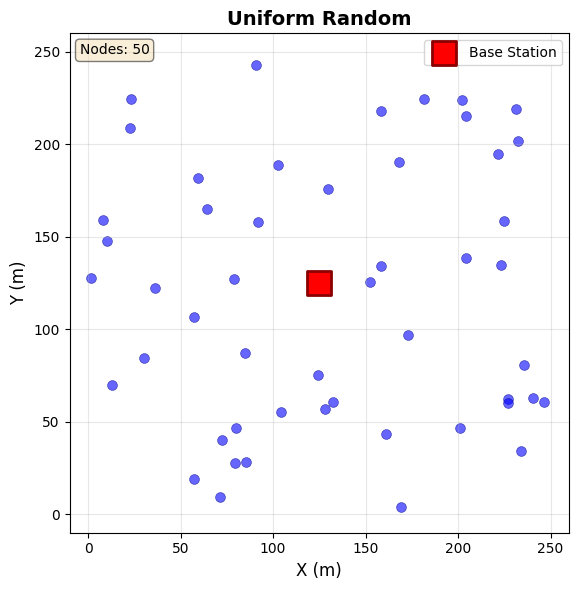

✓ Distribution plot saved: simulation_results/node_distributions.png

🚀 MULTI-RUN 1/20

SCENARIO: UNIFORM RANDOM

[Uniform Random] Running AC-ACO with fitness: old...

Starting AC-ACO simulation...
  ✓ Round clustering log started: simulation_results/round_clustering_Uniform Random_AC-ACO_old_20260113_075500.csv
  ✓ Round state file started: simulation_results/round_state_Uniform Random_AC-ACO_old_20260113_075500.csv

Round  250/3500
  Alive Nodes    :  50 (100.0%)
  Avg Energy     : 0.486500 J
  Total Consumed : 5.6750 J
  Num Clusters   : 5
  Best Fitness   : 0.9976

Round  500/3500
  Alive Nodes    :  49 ( 98.0%)
  Avg Energy     : 0.381586 J
  Total Consumed : 11.3028 J
  Num Clusters   : 5
  Best Fitness   : 0.8052

Round  750/3500
  Alive Nodes    :  44 ( 88.0%)
  Avg Energy     : 0.316516 J
  Total Consumed : 16.0773 J
  Num Clusters   : 4
  Best Fitness   : 0.6676

Round 1000/3500
  Alive Nodes    :  39 ( 78.0%)
  Avg Energy     : 0.249041 J
  Total Consumed : 20.2942 J
  Num C

In [ ]:

if __name__ == "__main__":
    main()
